In [1]:
# Instalaciones necesarias (solo una vez)
!pip install mediapipe opencv-python

In [2]:
# Imports estándar
import os, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models



In [3]:
# Drive y dispositivo
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [4]:
# Función para clasificar edades
def get_age_group(age):
    if age <= 20:
        return "Teen"
    elif age <= 40:
        return "Young adult"
    elif age <= 60:
        return "Middle-aged"
    else:
        return "Senior"

# Dataset personalizado
class UTKFaceDataset(Dataset):
    def __init__(self, folder_path, transform=None, max_images=None, min_age=11):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
        if max_images:
            self.image_files = self.image_files[:max_images]
        self.transform = transform

        self.data = []
        for filename in self.image_files:
            try:
                age, gender, _ = filename.split("_")[:3]
                age = int(age)
                gender = int(gender)
                if age < min_age:
                    continue  # 🧒 Excluir menores de 10 años
                age_group = get_age_group(age)
                self.data.append({
                    'filename': filename,
                    'age': age,
                    'gender': gender,
                    'age_group': age_group
                })
            except Exception as e:
                print(f"❌ Error parsing {filename}: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        img_path = os.path.join(self.folder_path, entry['filename'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, entry['gender'], entry['age'], entry['age_group'], entry['filename']



In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
import random

# 🎨 Transformaciones para 224x224
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# 📂 Cargar dataset filtrado (excluye <=10 años)
folder_path = "/content/drive/MyDrive/Colab Notebooks/MSC HEALTH DATA SCIENCE/Dissertation/UTKFace"
dataset_full = UTKFaceDataset(folder_path=folder_path, transform=None, max_images=30000, min_age=10)

# ✅ División estratificada por grupo de edad (con mínimo de 500 Teen en test)
indices_por_grupo = defaultdict(list)
for idx, sample in enumerate(dataset_full):
    _, _, age, group_age, _ = sample
    indices_por_grupo[group_age].append(idx)

test_indices, train_indices = [], []
for grupo, indices in indices_por_grupo.items():
    random.seed(42)
    random.shuffle(indices)
    if grupo == "Teen":
        n_test = max(int(0.2 * len(indices)), 400)
    else:
        n_test = int(0.2 * len(indices))
    test_indices.extend(indices[:n_test])
    train_indices.extend(indices[n_test:])

# Crear Subset a partir de los índices balanceados
train_ds = Subset(dataset_full, train_indices)
test_ds = Subset(dataset_full, test_indices)

# Aplicar transforms por separado
train_ds.dataset.transform = transform_train
test_ds.dataset.transform = transform_test

# ⚡ DataLoaders rápidos
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,
                          num_workers=4, pin_memory=True)

test_loader = DataLoader(test_ds, batch_size=64, shuffle=False,
                         num_workers=4, pin_memory=True)

print(f"✅ Dataset estratificado cargado: {len(train_ds)} entrenamiento | {len(test_ds)} test")



✅ Dataset estratificado cargado: 16481 entrenamiento | 4165 test


In [6]:
from collections import Counter

# Contar por grupo de edad
conteo_grupos = Counter([sample[3] for sample in test_ds])
print("🧮 Conteo por grupo de edad:")
for grupo, cantidad in conteo_grupos.items():
    print(f" - {grupo}: {cantidad} imágenes")

# Acceder directamente a los Teens
print(f"\n👦 Total de imágenes en el grupo 'Teen': {conteo_grupos['Teen']}")


🧮 Conteo por grupo de edad:
 - Senior: 479 imágenes
 - Middle-aged: 862 imágenes
 - Young adult: 2424 imágenes
 - Teen: 400 imágenes

👦 Total de imágenes en el grupo 'Teen': 400


In [7]:
from torchvision import models
import torch.nn as nn

def get_finetuned_vgg16_224():
    # 📥 Cargar VGG16 con pesos preentrenados
    vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # ❄️ Congelar todas las capas convolucionales
    for param in vgg.features.parameters():
        param.requires_grad = False

    # 🧠 Reemplazar el clasificador final
    vgg.classifier = nn.Sequential(
        nn.Linear(25088, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

    return vgg.to("cuda")



In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score
import torch

def train_model_vgg16_224(model, train_loader, test_loader, epochs=30, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = torch.nn.BCELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    best_acc = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].float().to("cuda")
            y = batch[1].float().to("cuda")  # ✅ Convertir a float
            optimizer.zero_grad()
            preds = model(x).squeeze()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if batch_idx % 40 == 0:
                print(f"🌀 Epoch {epoch+1} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

        val_loss, acc, auc = evaluate_model_vgg16(model, test_loader, criterion)
        print(f"📚 Epoch {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Val Acc: {acc:.2f}% | AUC: {auc:.4f}")
        scheduler.step(val_loss)

        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_vgg16_224.pt")

    print(f"✅ Entrenamiento finalizado. Mejor accuracy: {best_acc:.2f}%")

def evaluate_model_vgg16(model, loader, loss_fn):
    model.eval()
    all_probs, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            x = batch[0].float().to("cuda")
            y = batch[1].float().to("cuda")  # ✅ Convertir a float
            probs = model(x).squeeze()
            loss = loss_fn(probs, y)
            total_loss += loss.item()
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    preds_bin = [1 if p >= 0.5 else 0 for p in all_probs]
    acc = accuracy_score(all_labels, preds_bin) * 100
    auc = roc_auc_score(all_labels, all_probs)
    avg_loss = total_loss / len(loader)
    return avg_loss, acc, auc


In [9]:
model = get_finetuned_vgg16_224()
train_model_vgg16_224(model, train_loader, test_loader, epochs=30, lr=1e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 227MB/s]


🌀 Epoch 1 | Batch 0/258 | Loss: 0.6901
🌀 Epoch 1 | Batch 40/258 | Loss: 0.3163
🌀 Epoch 1 | Batch 80/258 | Loss: 0.2767
🌀 Epoch 1 | Batch 120/258 | Loss: 0.2243
🌀 Epoch 1 | Batch 160/258 | Loss: 0.3369
🌀 Epoch 1 | Batch 200/258 | Loss: 0.2398
🌀 Epoch 1 | Batch 240/258 | Loss: 0.1717
📚 Epoch 1/30 | Train Loss: 0.2590 | Val Acc: 92.10% | AUC: 0.9730
🌀 Epoch 2 | Batch 0/258 | Loss: 0.1781
🌀 Epoch 2 | Batch 40/258 | Loss: 0.1095
🌀 Epoch 2 | Batch 80/258 | Loss: 0.2457
🌀 Epoch 2 | Batch 120/258 | Loss: 0.1101
🌀 Epoch 2 | Batch 160/258 | Loss: 0.2261
🌀 Epoch 2 | Batch 200/258 | Loss: 0.1387
🌀 Epoch 2 | Batch 240/258 | Loss: 0.1178
📚 Epoch 2/30 | Train Loss: 0.1636 | Val Acc: 91.36% | AUC: 0.9755
🌀 Epoch 3 | Batch 0/258 | Loss: 0.0700
🌀 Epoch 3 | Batch 40/258 | Loss: 0.1542
🌀 Epoch 3 | Batch 80/258 | Loss: 0.1483
🌀 Epoch 3 | Batch 120/258 | Loss: 0.1198
🌀 Epoch 3 | Batch 160/258 | Loss: 0.0887
🌀 Epoch 3 | Batch 200/258 | Loss: 0.0893
🌀 Epoch 3 | Batch 240/258 | Loss: 0.0879
📚 Epoch 3/30 | Trai

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_model_evaluation(model, loader):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            x = batch[0].float().to("cuda")
            y = batch[1].float().to("cuda")  # ✅ Convertir explícitamente a float
            probs = model(x).squeeze()
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # 📌 Convertir a clases binarias con umbral 0.5
    preds = [1 if p >= 0.5 else 0 for p in all_probs]

    # 🔷 Matriz de Confusión
    cm = confusion_matrix(all_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Male", "Female"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix (1=Female, 0=Male)")
    plt.grid(False)
    plt.show()

    # 🔷 Curva ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='darkorange', linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve (gender classification)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


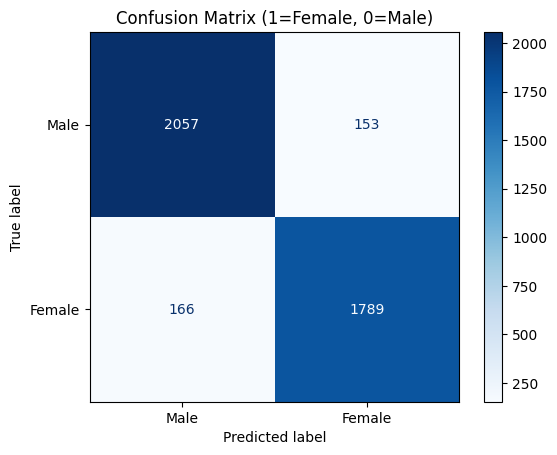

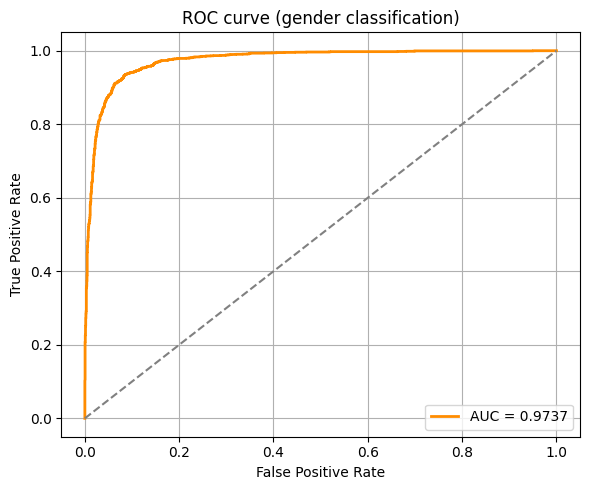

In [11]:
plot_model_evaluation(model, test_loader)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, loader, n=8):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(20, 5))

    with torch.no_grad():
        for batch in loader:
            x = batch[0].to("cuda")
            y = batch[1].to("cuda")  # ✅ Convertir a float si necesario, pero no afecta visualización
            preds = model(x).squeeze()
            preds_label = (preds > 0.5).long()
            for i in range(x.shape[0]):
                ax = fig.add_subplot(1, n, images_shown + 1)
                img = x[i].cpu().permute(1, 2, 0) * 0.5 + 0.5  # des-normalizar
                ax.imshow(img.numpy())
                pred = "Male" if preds_label[i] == 0 else "Female"
                true = "Male" if y[i] == 0 else "Female"
                color = "green" if pred == true else "red"
                ax.set_title(f"P: {pred}\nT: {true}", color=color)
                ax.axis("off")
                images_shown += 1
                if images_shown >= n:
                    plt.tight_layout()
                    plt.show()
                    return

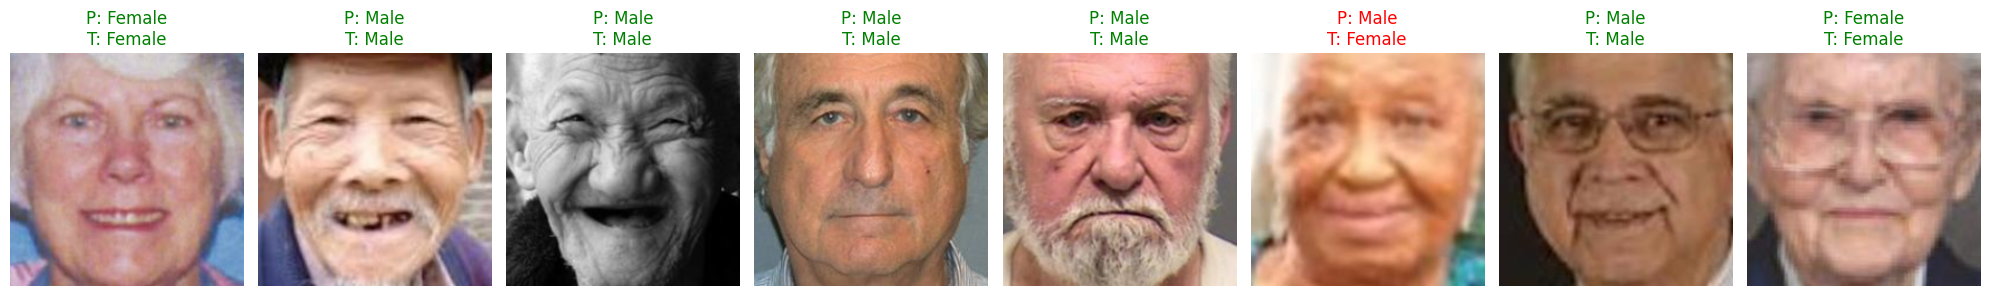

In [13]:
show_predictions(model, test_loader, n=8)

In [14]:
# Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer, device):
        self.model = model
        self.target_layer = target_layer
        self.device = device
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(self._forward_hook)
                module.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_tensor):
        input_tensor = input_tensor.unsqueeze(0).to(self.device)
        input_tensor.requires_grad = True

        output = self.model(input_tensor)
        score = output.squeeze()
        if score.dim() > 0:
            score = score[0]

        self.model.zero_grad()
        score.backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam_resized = cv2.resize(cam.cpu().numpy(), (224, 224))
        return cam_resized

# Score-CAM
class ScoreCAM:
    def __init__(self, model, target_layer, device):
        self.model = model
        self.target_layer = target_layer
        self.device = device
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(self._hook_fn)

    def _hook_fn(self, module, input, output):
        self.activations = output.detach()

    def generate_cam(self, input_tensor):
        input_tensor = input_tensor.unsqueeze(0).to(self.device)
        _ = self.model(input_tensor)
        activations = self.activations.squeeze(0)
        weights = []
        upsampled = []

        for i in range(activations.shape[0]):
            fmap = activations[i].cpu().numpy()
            fmap_norm = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
            fmap_resized = cv2.resize(fmap_norm, (224, 224))
            mask = torch.from_numpy(fmap_resized).unsqueeze(0).unsqueeze(0).to(self.device)
            masked_img = input_tensor * mask

            with torch.no_grad():
                score = self.model(masked_img).squeeze()
                if score.dim() > 0:
                    score = score[0]
                score = score.item()

            weights.append(score)
            upsampled.append(fmap_resized)

        weights = np.array(weights)
        upsampled = np.stack(upsampled)
        cam = np.sum(weights[:, None, None] * upsampled, axis=0)
        cam = np.maximum(cam, 0)
        cam -= cam.min()
        cam /= cam.max() + 1e-8
        return cam


In [15]:
vgg_gender = model  # o el nombre de tu modelo entrenado
device = torch.device("cuda")

gradcam = GradCAM(model=vgg_gender, target_layer="features.28", device=device)
scorecam = ScoreCAM(model=vgg_gender, target_layer="features.28", device=device)

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

def visualize_cam_on_image(dataset, model, gradcam, scorecam, idx=0):
    model.eval()
    image, gender, _, _, filename = dataset[idx]
    input_tensor = image.to(device)

    # 🎯 Obtener mapas
    gradcam_map = gradcam.generate_cam(input_tensor)
    scorecam_map = scorecam.generate_cam(input_tensor)

    # 🖼️ Convertir imagen original para visualización
    img_np = image.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np * 0.5 + 0.5) * 255  # desnormalizar
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)

    # 🔥 Superponer heatmaps
    def overlay_cam(cam, img):
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = heatmap * 0.4 + img
        return np.uint8(np.clip(overlay, 0, 255))

    overlay_grad = overlay_cam(gradcam_map, img_np)
    overlay_score = overlay_cam(scorecam_map, img_np)

    # 🖼️ Mostrar resultados
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title(f"Original ({'Female' if gender==1 else 'Male'})")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(overlay_grad)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_score)
    plt.title("Score-CAM")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


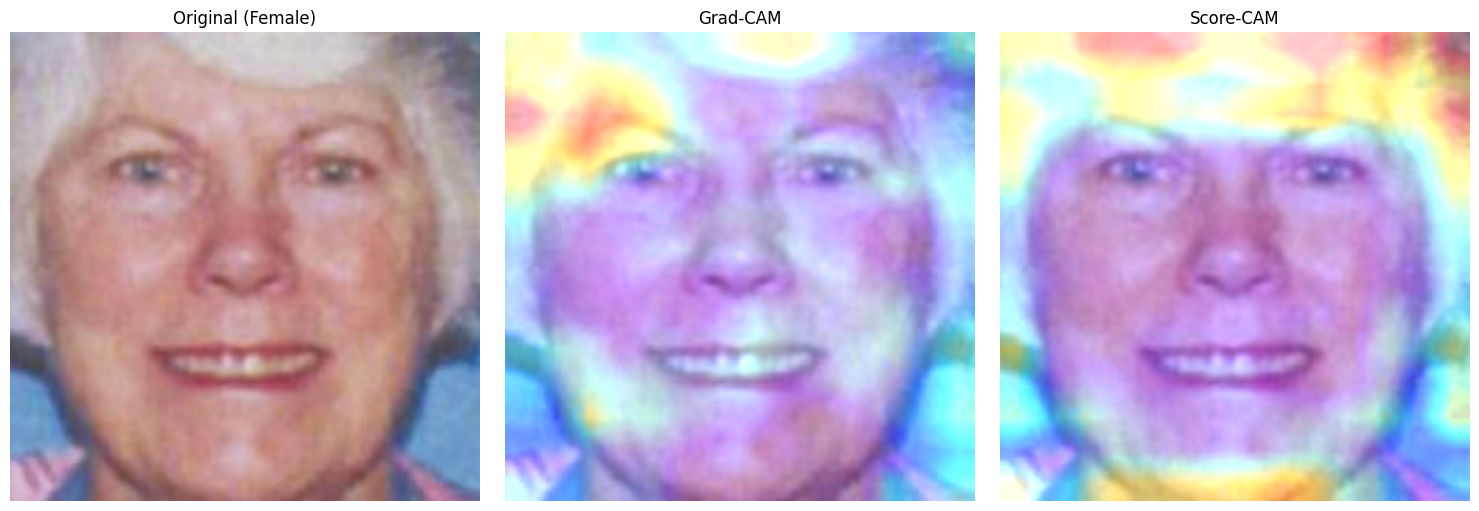

In [17]:
visualize_cam_on_image(test_ds, vgg_gender, gradcam, scorecam, idx=0)

In [18]:
import mediapipe as mp

# Inicializar FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

# Regiones anatómicas basadas en landmarks de MediaPipe
regiones = {
    "left_eye": [33, 160, 158, 133, 153, 144, 145],
    "right_eye": [362, 385, 387, 263, 373, 380, 374],
    "lips": [152, 148, 176, 149, 150, 18, 88, 199, 200, 201, 202, 329, 330, 331, 332, 333],
    "chin_center": [152, 148, 176, 149, 150],
    "chin_left": [136, 172, 58, 17],
    "chin_right": [365, 397, 288, 18],
    "left_cheek": [203, 204, 205, 50],
    "right_cheek": [425, 426, 291, 294, 278],
    "left_temple": [127, 234, 93],
    "right_temple": [356, 454, 323],
    "forehead": [10, 338, 297, 109, 67, 295, 282, 8],
    "left_cheekbone": [50, 101, 118, 205],
    "right_cheekbone": [291, 305, 334, 426],
    "nose": [1, 2, 4, 5, 6, 97, 327, 330, 168, 195],
    "left_eyebrow": [65, 70, 63, 105, 66],
    "right_eyebrow": [295, 336, 296, 334, 293],
    "left_jaw": [132, 137, 149, 234],
    "right_jaw": [361, 366, 288, 454]
}

# Sigma personalizado por región para difuminar la máscara
sigmas_por_region = {
    "left_eye": 7, "right_eye": 7,
    "lips": 14,
    "chin_center": 11, "chin_left": 10, "chin_right": 10,
    "left_cheek": 13, "right_cheek": 13,
    "left_temple": 10, "right_temple": 10,
    "forehead": 20,
    "left_cheekbone": 10, "right_cheekbone": 10,
    "nose": 13,
    "left_eyebrow": 8, "right_eyebrow": 8,
    "left_jaw": 15, "right_jaw": 15
}

# Función para crear máscara gaussiana centrada en (x, y)
def gaussian_mask(center, shape=(224, 224), sigma=10):
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    mask = np.exp(-((x - center[0])**2 + (y - center[1])**2) / (2 * sigma**2))
    return mask / mask.max()

# Detección de landmarks y creación de máscaras
def detectar_landmarks_y_mascaras(image_tensor):
    # De-normalizar imagen
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)
    image_rgb = (image_np * 255).astype(np.uint8)

    # Detección con MediaPipe
    results = face_mesh.process(image_rgb)
    if not results.multi_face_landmarks:
        return None

    height, width, _ = image_rgb.shape
    landmarks = results.multi_face_landmarks[0].landmark
    puntos = [(int(lm.x * width), int(lm.y * height)) for lm in landmarks]

    # Crear máscaras por región
    masks = {}
    for region, idxs in regiones.items():
        region_pts = [puntos[i] for i in idxs if i < len(puntos)]
        if not region_pts:
            continue
        x_mean = int(np.mean([p[0] for p in region_pts]))
        y_mean = int(np.mean([p[1] for p in region_pts]))
        sigma = sigmas_por_region.get(region, 10)
        masks[region] = gaussian_mask(center=(x_mean, y_mean), shape=(224, 224), sigma=sigma)

    return puntos, masks


In [19]:
# Cuantificar activación CAM en cada región anatómica
def cuantificar_activacion_soft(cam_norm, masks):
    total = cam_norm.sum()
    activaciones = {}
    used_pixels = np.zeros_like(cam_norm, dtype=bool)

    for region, mask in masks.items():
        activacion = (cam_norm * mask).sum()
        activaciones[region] = float(activacion / total) if total > 0 else 0.0
        used_pixels |= (mask > 0.01)

    activaciones["other"] = float(cam_norm[~used_pixels].sum() / total) if total > 0 else 0.0
    return activaciones


In [20]:
# Crear mapa semántico a partir de activaciones
def generar_semantic_map(activaciones, masks):
    mapa = np.zeros((224, 224))
    for region, mask in masks.items():
        peso = activaciones.get(region, 0.0)
        mapa += peso * mask
    mapa = np.clip(mapa * 5, 0, 1)
    return mapa


In [21]:
# Procesar lote completo (exporta CSV)
def procesar_batch_semantic(val_loader, gradcam, scorecam, save_path, max_images=20000):
    registros = []
    count = 0

    for batch in val_loader:
        image, label, age, group_age, filename = batch
        image = image[0].to(device)
        label = int(label[0].item())
        age = int(age[0].item())
        group_age = group_age[0]
        filename = filename[0]

        resultado = detectar_landmarks_y_mascaras(image.cpu())
        if resultado is None:
            continue
        puntos, masks = resultado

        try:
            cam_grad = gradcam.generate_cam(image)
            cam_score = scorecam.generate_cam(image)

            act_grad = cuantificar_activacion_soft(cam_grad, masks)
            act_score = cuantificar_activacion_soft(cam_score, masks)

            fila = {
                "filename": filename,
                "label": label,
                "age": age,
                "age_group": group_age
            }

            for region in act_grad:
                fila[f"{region}_grad"] = act_grad[region]
                fila[f"{region}_score"] = act_score[region]

            registros.append(fila)
            count += 1
            if count >= max_images:
                break
        except Exception as e:
            print(f"❌ Error en imagen {filename}: {e}")
            continue

    df = pd.DataFrame(registros)
    df.to_csv(save_path, index=False)
    print(f"Activations stored in: {save_path}")


In [22]:
from collections import defaultdict
import random
from torch.utils.data import Subset, DataLoader

output_csv_balanceado = "/content/drive/MyDrive/Colab Notebooks/MSC HEALTH DATA SCIENCE/Dissertation/UTKFace/semantic_activation_morphoXAI_balancead_vf2.csv"
procesar_batch_semantic(test_loader, gradcam, scorecam, save_path=output_csv_balanceado, max_images=20000)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Activations stored in: /content/drive/MyDrive/Colab Notebooks/MSC HEALTH DATA SCIENCE/Dissertation/UTKFace/semantic_activation_morphoXAI_balancead_vf2.csv


In [23]:
from matplotlib import cm

def visualizar_comparacion_semantic(image_tensor, label, gradcam, scorecam):
    resultado = detectar_landmarks_y_mascaras(image_tensor.cpu())
    if resultado is None:
        print("❌ No se detectaron landmarks.")
        return

    puntos, masks = resultado

    # Obtener CAMs
    cam_grad = gradcam.generate_cam(image_tensor)
    cam_score = scorecam.generate_cam(image_tensor)

    # Activación por región
    act_grad = cuantificar_activacion_soft(cam_grad, masks)
    act_score = cuantificar_activacion_soft(cam_score, masks)

    # Mapas semánticos
    mapa_grad = generar_semantic_map(act_grad, masks)
    mapa_score = generar_semantic_map(act_score, masks)

    # Imagen original
    orig_img = image_tensor.detach().cpu().permute(1, 2, 0).numpy()
    orig_img = (orig_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    orig_img = np.clip(orig_img, 0, 1) ** 0.8

    # Heatmaps
    cmap = cm.get_cmap('jet')
    overlay_grad = np.clip(0.5 * orig_img + 0.5 * cmap(mapa_grad)[..., :3], 0, 1)
    overlay_score = np.clip(0.5 * orig_img + 0.5 * cmap(mapa_score)[..., :3], 0, 1)

    # Mostrar
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(overlay_grad)
    plt.title("Semantic Map - Grad-CAM")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay_score)
    plt.title("Semantic Map - Score-CAM")
    plt.axis("off")

    clase = "Mujer" if label == 1 else "Hombre"
    plt.suptitle(f"Clase verdadera: {clase}", fontsize=14)
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-23-819438206.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')


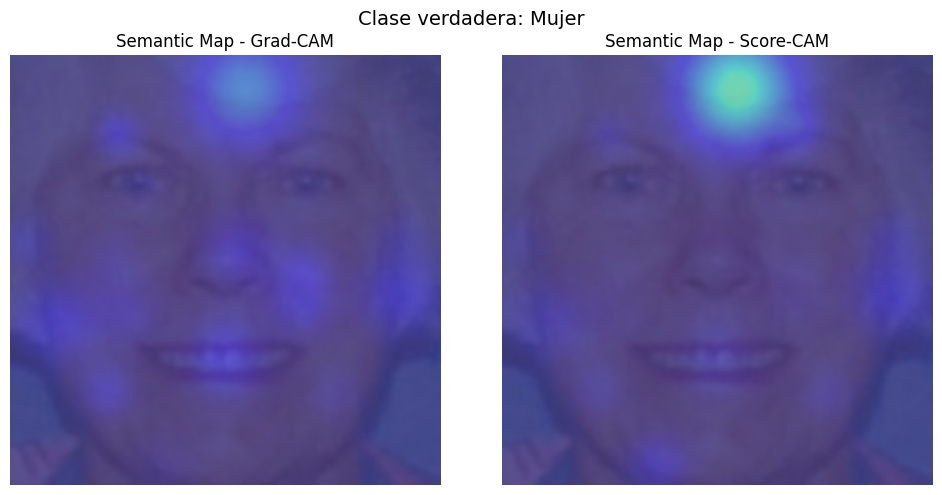

In [24]:
# ✅ Extraer un solo ejemplo del test_loader (batch de 64 → tomar el primero)
sample_batch = next(iter(test_loader))
image = sample_batch[0][0].to(device)  # Primera imagen del batch
label = int(sample_batch[1][0].item()) # Primera etiqueta (0=Male, 1=Female)

# ✅ Visualizar activaciones semánticas
visualizar_comparacion_semantic(image, label, gradcam, scorecam)


In [25]:
def visualizar_mascaras_superpuestas_con_etiquetas(image_tensor, masks):
    # Imagen original
    orig_img = image_tensor.detach().cpu().permute(1, 2, 0).numpy()
    orig_img = (orig_img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    orig_img = np.clip(orig_img, 0, 1)

    overlay = np.copy(orig_img)
    color_map = plt.cm.get_cmap('hsv', len(masks))

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(overlay)

    for i, (region, mask) in enumerate(masks.items()):
        color = color_map(i)[:3]
        mask_rgb = np.stack([mask * c for c in color], axis=-1)
        overlay = np.clip(overlay + mask_rgb * 0.5, 0, 1)

        # Etiquetar región (en centroide de máscara)
        ys, xs = np.where(mask > 0.2)
        if len(xs) > 0:
            x_mean = int(np.mean(xs))
            y_mean = int(np.mean(ys))
            ax.text(x_mean, y_mean, region.replace("_", "\n"), fontsize=7,
                    color='white', ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.5))

    ax.imshow(overlay)
    ax.set_title("Anatomical overlay masks with labels")
    ax.axis("off")
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-25-3644255261.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('hsv', len(masks))


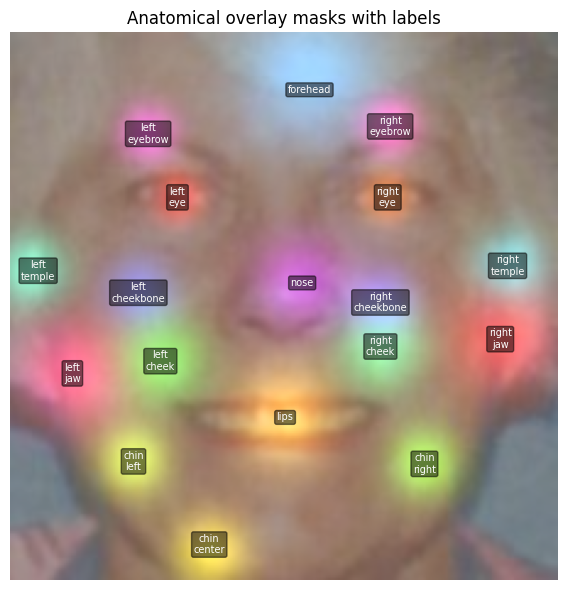

In [26]:
# Ejecutar en una imagen del test_loader
sample_batch = next(iter(test_loader))  # ⚠️ test_loader está correctamente definido
image = sample_batch[0][0].to(device)   # Primera imagen del batch

resultado = detectar_landmarks_y_mascaras(image.cpu())
if resultado is not None:
    puntos, masks = resultado
    visualizar_mascaras_superpuestas_con_etiquetas(image, masks)
else:
    print("❌ No se detectaron landmarks.")


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar archivo CSV generado
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSC HEALTH DATA SCIENCE/Dissertation/UTKFace/semantic_activation_morphoXAI_balancead_vf2.csv")

# Mapear etiqueta binaria a género
df["Gender"] = df["label"].map({0: "Male", 1: "Female"})

# Extraer columnas de activación
grad_cols = [c for c in df.columns if c.endswith("_grad")]
score_cols = [c for c in df.columns if c.endswith("_score")]


In [28]:
# Promedio por grupo de edad y género
df_grad = df.groupby(["age_group", "Gender"])[grad_cols].mean().reset_index()
df_score = df.groupby(["age_group", "Gender"])[score_cols].mean().reset_index()

# Formato largo para heatmap
df_grad_melted = df_grad.melt(id_vars=["age_group", "Gender"], var_name="Region", value_name="Activación")
df_score_melted = df_score.melt(id_vars=["age_group", "Gender"], var_name="Region", value_name="Activación")

df_grad_melted["Region"] = df_grad_melted["Region"].str.replace("_grad", "")
df_score_melted["Region"] = df_score_melted["Region"].str.replace("_score", "")


In [29]:
from scipy.stats import mannwhitneyu

def test_mannwhitney_por_region(df, columnas_score, columnas_grad):
    resultados = []

    for grad_col, score_col in zip(columnas_grad, columnas_score):
        region = grad_col.replace("_grad", "")
        hombres_g = df[df["Gender"] == "Male"][grad_col]
        mujeres_g = df[df["Gender"] == "Female"][grad_col]
        stat_g, p_g = mannwhitneyu(hombres_g, mujeres_g, alternative="two-sided")

        hombres_s = df[df["Gender"] == "Male"][score_col]
        mujeres_s = df[df["Gender"] == "Female"][score_col]
        stat_s, p_s = mannwhitneyu(hombres_s, mujeres_s, alternative="two-sided")

        resultados.append({
            "Region": region,
            "p-valuw Grad-CAM": p_g,
            "Significant Grad-CAM": "✅" if p_g < 0.05 else "—",
            "p-value Score-CAM": p_s,
            "Significant Score-CAM": "✅" if p_s < 0.05 else "—"
        })

    df_test = pd.DataFrame(resultados).sort_values("p-value Score-CAM")
    return df_test

# Ejecutar
df_test_mwu = test_mannwhitney_por_region(df, score_cols, grad_cols)
display(df_test_mwu)



Region  p-valuw Grad-CAM Significant Grad-CAM  p-value Score-CAM  \
3       chin_center      1.963666e-01                    —           0.002610   
15    right_eyebrow      3.325554e-01                    —           0.021465   
12  right_cheekbone      9.858622e-04                    ✅           0.081131   
1         right_eye      8.811909e-02                    —           0.133954   
9      right_temple      1.619268e-03                    ✅           0.210128   
0          left_eye      2.004252e-02                    ✅           0.224574   
14     left_eyebrow      3.751855e-02                    ✅           0.244921   
11   left_cheekbone      8.001290e-07                    ✅           0.255565   
17        right_jaw      9.059914e-03                    ✅           0.261006   
10         forehead      5.963138e-01                    —           0.289410   
4         chin_left      1.339545e-01                    —           0.295331   
5        chin_right      1.052440e-02                    ✅           0.313580   
16         left_jaw      1.456332e-04                    ✅           0.445902   
7       right_cheek      2.449206e-01                    —           0.453650   
18            other      6.887798e-01                    —           0.485387   
8       left_temple      1.054783e-05                    ✅           0.578520   
6        left_cheek      2.016340e-03                    ✅           0.660465   
13             nose      1.790610e-01                    —           0.717537   
2              lips      4.010305e-01                    —           0.876792   

   Significant Score-CAM  
3                      ✅  
15                     ✅  
12                     —  
1                      —  
9                      —  
0                      —  
14                     —  
11                     —  
17                     —  
10                     —  
4                      —  
5                      —  
16                     —  
7                      —  
18                     —  
8                      —  
6                      —  
13                     —  
2                      —

In [30]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

def calcular_odds_ratios(X_cols, df, label_col="label", nombre="Score-CAM"):
    X = df[X_cols]
    y = df[label_col]

    # Escalar
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Modelo
    X_sm = sm.add_constant(X_scaled)
    model = sm.Logit(y, X_sm).fit(disp=0)

    # Resultados
    resultados = pd.DataFrame({
        "Region": X.columns,
        "Odds Ratio": np.exp(model.params[1:]),
        "p-value": model.pvalues[1:],
        "CI 2.5%": np.exp(model.conf_int().iloc[1:, 0]),
        "CI 97.5%": np.exp(model.conf_int().iloc[1:, 1]),
        "Method": nombre
    })

    return resultados.sort_values("Odds Ratio", ascending=False)

# Ejecutar para ambas técnicas
odds_score = calcular_odds_ratios(score_cols, df, nombre="Score-CAM")
odds_grad = calcular_odds_ratios(grad_cols, df, nombre="Grad-CAM")

# Combinar para comparar
odds_comparado = pd.concat([odds_score, odds_grad], axis=0)
display(odds_comparado)



Region  Odds Ratio   p-value   CI 2.5%  \
right_cheekbone_score  right_cheekbone_score   12.152438  0.018203  1.529040   
left_cheekbone_score    left_cheekbone_score    3.774233  0.126931  0.685670   
right_eyebrow_score      right_eyebrow_score    2.555013  0.138444  0.738701   
left_temple_score          left_temple_score    1.980613  0.166334  0.752503   
right_temple_score        right_temple_score    1.499620  0.471537  0.497642   
left_cheek_score            left_cheek_score    1.012176  0.985495  0.274532   
chin_right_score            chin_right_score    0.947661  0.935642  0.257017   
left_jaw_score                left_jaw_score    0.782187  0.695198  0.228884   
left_eye_score                left_eye_score    0.522665  0.274090  0.163404   
right_cheek_score          right_cheek_score    0.453699  0.357404  0.084296   
lips_score                        lips_score    0.297770  0.125524  0.063211   
forehead_score                forehead_score    0.282746  0.044155  0.082631   
left_eyebrow_score        left_eyebrow_score    0.253688  0.036927  0.069943   
right_jaw_score              right_jaw_score    0.242888  0.045087  0.060851   
other_score                      other_score    0.217307  0.114260  0.032687   
chin_left_score              chin_left_score    0.155959  0.012078  0.036545   
nose_score                        nose_score    0.114921  0.004630  0.025707   
chin_center_score          chin_center_score    0.097919  0.004316  0.019855   
right_eye_score              right_eye_score    0.083995  0.006943  0.013907   
left_cheekbone_grad      left_cheekbone_grad  226.285731  0.004469  5.386993   
left_jaw_grad                  left_jaw_grad   29.242739  0.020250  1.692030   
chin_right_grad              chin_right_grad    5.672645  0.098361  0.724336   
left_eyebrow_grad          left_eyebrow_grad    3.619342  0.111163  0.743548   
right_temple_grad          right_temple_grad    3.368368  0.221921  0.479845   
forehead_grad                  forehead_grad    3.048710  0.342868  0.304622   
lips_grad                          lips_grad    2.195964  0.390922  0.364072   
other_grad                        other_grad    2.044120  0.647541  0.095355   
left_eye_grad                  left_eye_grad    1.767430  0.596011  0.215234   
right_jaw_grad                right_jaw_grad    1.501481  0.605397  0.321278   
nose_grad                          nose_grad    1.483044  0.713673  0.180686   
chin_center_grad            chin_center_grad    1.417640  0.671218  0.282964   
right_cheekbone_grad    right_cheekbone_grad    1.101127  0.930877  0.124881   
left_temple_grad            left_temple_grad    1.098916  0.880477  0.321368   
right_cheek_grad            right_cheek_grad    0.749217  0.825939  0.057155   
right_eye_grad                right_eye_grad    0.540118  0.636834  0.041876   
chin_left_grad                chin_left_grad    0.351827  0.363699  0.036934   
right_eyebrow_grad        right_eyebrow_grad    0.281712  0.450355  0.010500   
left_cheek_grad              left_cheek_grad    0.003440  0.007217  0.000055   

                          CI 97.5%     Method  
right_cheekbone_score    96.584625  Score-CAM  
left_cheekbone_score     20.775065  Score-CAM  
right_eyebrow_score       8.837252  Score-CAM  
left_temple_score         5.213036  Score-CAM  
right_temple_score        4.519036  Score-CAM  
left_cheek_score          3.731805  Score-CAM  
chin_right_score          3.494177  Score-CAM  
left_jaw_score            2.673036  Score-CAM  
left_eye_score            1.671801  Score-CAM  
right_cheek_score         2.441915  Score-CAM  
lips_score                1.402729  Score-CAM  
forehead_score            0.967495  Score-CAM  
left_eyebrow_score        0.920139  Score-CAM  
right_jaw_score           0.969486  Score-CAM  
other_score               1.444674  Score-CAM  
chin_left_score           0.665565  Score-CAM  
nose_score                0.513742  Score-CAM  
chin_center_score         0.482892  Score-CAM  
right

In [31]:
df_box = []
for region in score_cols:
    region_name = region.replace("_score", "")
    for _, row in df.iterrows():
        df_box.append({
            "Region": region_name,
            "Activation": row[region],
            "Gender": row["Gender"],
            "AgeGroup": row["age_group"]
        })

df_box = pd.DataFrame(df_box)

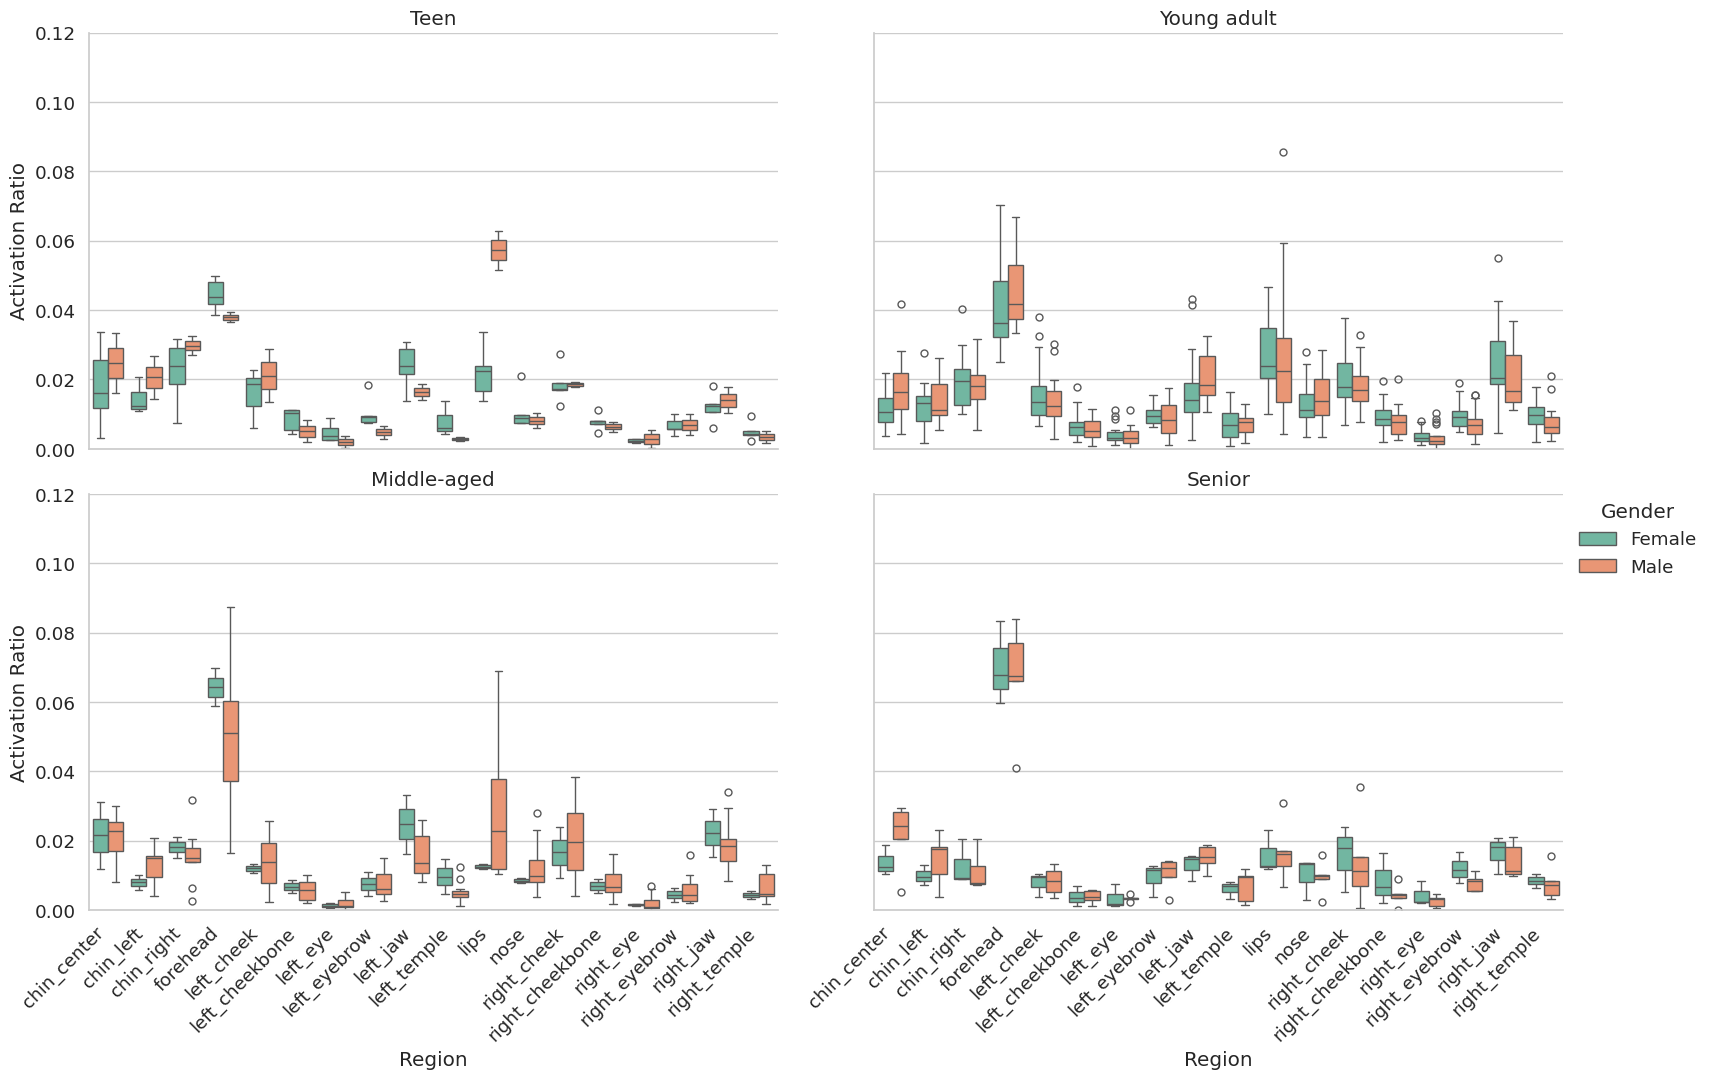

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 🔁 Asegúrate de eliminar la región "other"
df_box = df_box[df_box["Region"] != "other"]

# ✅ Extraer y ordenar nombres de regiones
regiones_validas = sorted([col.replace("_score", "") for col in score_cols if "other" not in col])
df_box["Region"] = pd.Categorical(df_box["Region"], categories=regiones_validas, ordered=True)

# ✅ Orden deseado para grupos de edad
orden_grupos = ["Teen", "Young adult", "Middle-aged", "Senior"]

# 🎨 Estilo visual
sns.set(style="whitegrid", font_scale=1.2)

# 📊 Visualización
g = sns.catplot(
    data=df_box,
    kind="box",
    x="Region", y="Activation",
    hue="Gender", col="AgeGroup",
    col_order=orden_grupos,
    col_wrap=2,
    height=5, aspect=1.6,
    palette="Set2",
    showfliers=True,
    linewidth=1.0
)

g.set_titles("{col_name}")
g.set_axis_labels("Region", "Activation Ratio")

# 🔁 Rotar etiquetas del eje X correctamente
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
    ax.set_ylim(0, 0.12)





In [33]:
# Crear df_box_grad con los mismos registros pero activaciones de Grad-CAM
df_box_grad = []
for region in grad_cols:
    region_name = region.replace("_grad", "")
    if region_name == "other":
        continue
    for _, row in df.iterrows():
        df_box_grad.append({
            "Region": region_name,
            "Activation": row[region],
            "Gender": row["Gender"],
            "AgeGroup": row["age_group"]
        })

df_box_grad = pd.DataFrame(df_box_grad)

# Orden explícito para regiones y grupos
regiones_validas = sorted([col.replace("_grad", "") for col in grad_cols if "other" not in col])
df_box_grad["Region"] = pd.Categorical(df_box_grad["Region"], categories=regiones_validas, ordered=True)
orden_grupos = ["Teen", "Young adult", "Middle-aged", "Senior"]


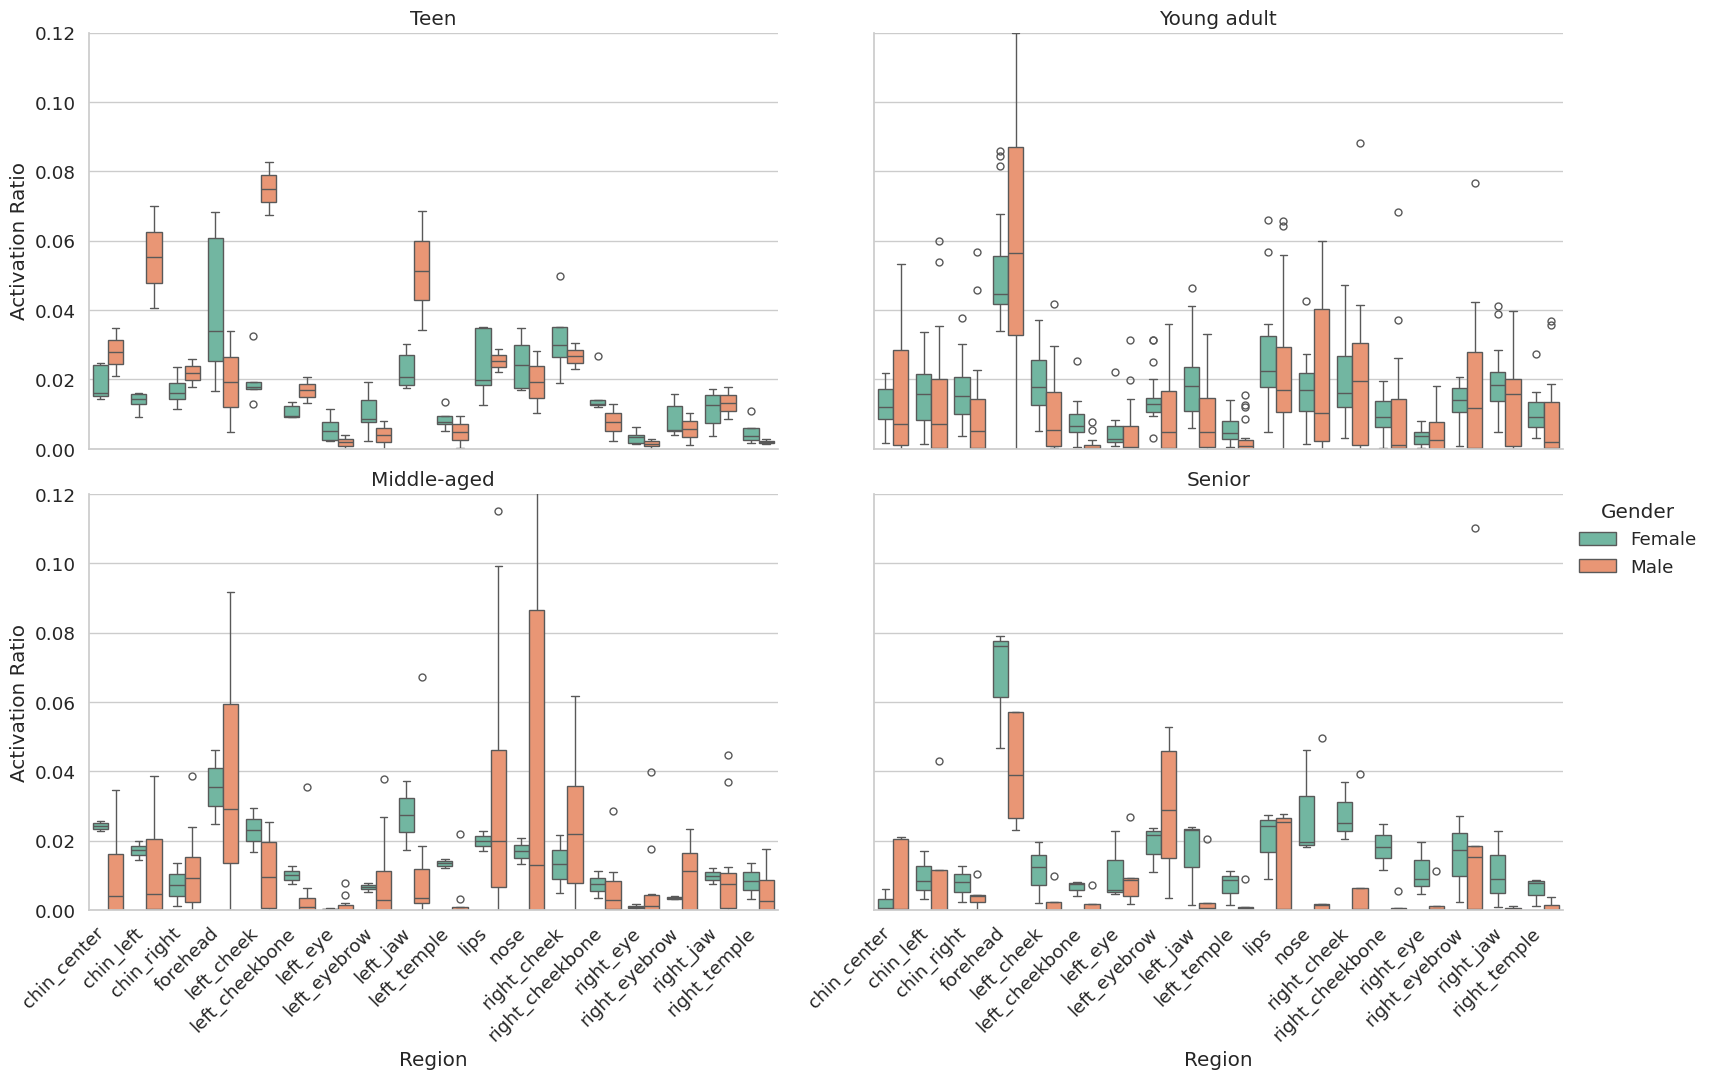

In [34]:
# Estilo y paleta
sns.set(style="whitegrid", font_scale=1.2)

# Generar los subplots por grupo de edad
g = sns.catplot(
    data=df_box_grad,
    kind="box",
    x="Region", y="Activation",
    hue="Gender", col="AgeGroup",
    col_order=orden_grupos,
    col_wrap=2,
    height=5, aspect=1.6,
    palette="Set2",
    showfliers=True,
    linewidth=1.0
)

g.set_titles("{col_name}")
g.set_axis_labels("Region", "Activation Ratio")

# Rotar etiquetas del eje X y fijar límites
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
    ax.set_ylim(0, 0.12)


In [35]:
# 🔁 Preparar df_box_score con activaciones Score-CAM
df_box_score = df_box.copy()
df_box_score["Method"] = "Score-CAM"
df_box_score["Activation"] = df_box_score.apply(
    lambda row: df.loc[
        (df["Gender"] == row["Gender"]) &
        (df["age_group"] == row["AgeGroup"]),
        f"{row['Region']}_score"
    ].values[0],
    axis=1
)

# 🔁 Preparar df_box_grad con activaciones Grad-CAM
df_box_grad = df_box.copy()
df_box_grad["Method"] = "Grad-CAM"
df_box_grad["Activation"] = df_box_grad.apply(
    lambda row: df.loc[
        (df["Gender"] == row["Gender"]) &
        (df["age_group"] == row["AgeGroup"]),
        f"{row['Region']}_grad"
    ].values[0],
    axis=1
)

# 🔗 Unir en un único DataFrame
df_box_combined = pd.concat([df_box_score, df_box_grad], ignore_index=True)


In [36]:
import statsmodels.formula.api as smf

def anova_interaccion(df_box, metodo):
    resultados = []
    for region in df_box["Region"].unique():
        sub = df_box[(df_box["Region"] == region) & (df_box["Method"] == metodo)]
        if sub["Activation"].nunique() > 1:  # evitar errores por falta de variación
            modelo = smf.ols("Activation ~ C(Gender) * C(AgeGroup)", data=sub).fit()
            tabla = sm.stats.anova_lm(modelo, typ=2)
            p_interaccion = tabla.loc["C(Gender):C(AgeGroup)", "PR(>F)"]
            resultados.append({
                "Region": region,
                "p-value Interaction": p_interaccion,
                "Significant": "✅" if p_interaccion < 0.05 else "—",
                "Method": metodo
            })
    return pd.DataFrame(resultados)


In [37]:
# Ejecutar ANOVA para ambos métodos
anova_score = anova_interaccion(df_box_combined, "Score-CAM")
anova_grad = anova_interaccion(df_box_combined, "Grad-CAM")
anova_total = pd.concat([anova_score, anova_grad], ignore_index=True)

# Resumen final: cuántas regiones significativas por técnica
resumen = (
    anova_total[anova_total["Significant"] == "✅"]
    .groupby("Method")
    .size()
    .reset_index(name="Regions with significant interaction")
)

print("Regions with significant interaction by method:")
display(resumen)

print("\n Full detail ANOVA by region:")
display(anova_total.sort_values(["Method", "p-value Interaction"]))


Regions with significant interaction by method:


Method  Regions with significant interaction
0   Grad-CAM                                    18
1  Score-CAM                                    18


 Full detail ANOVA by region:


Region  p-value Interaction Significant     Method
18         left_eye                  0.0           ✅   Grad-CAM
19        right_eye                  0.0           ✅   Grad-CAM
20             lips                  0.0           ✅   Grad-CAM
21      chin_center                  0.0           ✅   Grad-CAM
22        chin_left                  0.0           ✅   Grad-CAM
23       chin_right                  0.0           ✅   Grad-CAM
24       left_cheek                  0.0           ✅   Grad-CAM
25      right_cheek                  0.0           ✅   Grad-CAM
26      left_temple                  0.0           ✅   Grad-CAM
27     right_temple                  0.0           ✅   Grad-CAM
28         forehead                  0.0           ✅   Grad-CAM
29   left_cheekbone                  0.0           ✅   Grad-CAM
30  right_cheekbone                  0.0           ✅   Grad-CAM
31             nose                  0.0           ✅   Grad-CAM
32     left_eyebrow                  0.0           ✅   Grad-CAM
33    right_eyebrow                  0.0           ✅   Grad-CAM
34         left_jaw                  0.0           ✅   Grad-CAM
35        right_jaw                  0.0           ✅   Grad-CAM
0          left_eye                  0.0           ✅  Score-CAM
1         right_eye                  0.0           ✅  Score-CAM
2              lips                  0.0           ✅  Score-CAM
3       chin_center                  0.0           ✅  Score-CAM
4         chin_left                  0.0           ✅  Score-CAM
5        chin_right                  0.0           ✅  Score-CAM
6        left_cheek                  0.0           ✅  Score-CAM
7       right_cheek                  0.0           ✅  Score-CAM
8       left_temple                  0.0           ✅  Score-CAM
9      right_temple                  0.0           ✅  Score-CAM
10         forehead                  0.0           ✅  Score-CAM
11   left_cheekbone                  0.0           ✅  Score-CAM
12  right_cheekbone                  0.0           ✅  Score-CAM
13             nose                  0.0           ✅  Score-CAM
14     left_eyebrow                  0.0           ✅  Score-CAM
15    right_eyebrow                  0.0           ✅  Score-CAM
16         left_jaw                  0.0           ✅  Score-CAM
17        right_jaw                  0.0           ✅  Score-CAM

In [38]:
# Crear tabla media por grupo de edad y género
resumen_regiones = []

for region in score_cols:
    nombre_region = region.replace("_score", "")
    if nombre_region == "other":
        continue
    for grupo in df["age_group"].unique():
        hombres = df[(df["age_group"] == grupo) & (df["Gender"] == "Male")][region]
        mujeres = df[(df["age_group"] == grupo) & (df["Gender"] == "Female")][region]

        media_h = hombres.mean()
        media_m = mujeres.mean()
        diferencia = media_m - media_h

        resumen_regiones.append({
            "Age Group": grupo,
            "Region": nombre_region,
            "Male Average": media_h,
            "Female Average": media_m,
            "Difference (F - M)": diferencia,
            "Absolute Difference": abs(diferencia)
        })

df_regiones_score = pd.DataFrame(resumen_regiones)


In [39]:
# Top 3 regiones con mayor diferencia absoluta por grupo
top3_por_grupo = (
    df_regiones_score
    .sort_values(["Age Group", "Absolute Difference"], ascending=[True, False])
    .groupby("Age Group")
    .head(3)
)

display(top3_por_grupo)


Age Group           Region  Male Average  Female Average  \
9   Middle-aged             lips      0.028410        0.012546   
41  Middle-aged         forehead      0.050351        0.064197   
65  Middle-aged         left_jaw      0.015910        0.024764   
12       Senior      chin_center      0.021491        0.013800   
16       Senior        chin_left      0.014610        0.009983   
48       Senior  right_cheekbone      0.004265        0.008430   
11         Teen             lips      0.057232        0.022106   
23         Teen       chin_right      0.029730        0.022110   
67         Teen         left_jaw      0.016344        0.023789   
14  Young adult      chin_center      0.017443        0.011264   
42  Young adult         forehead      0.045995        0.040842   
70  Young adult        right_jaw      0.020058        0.024877   

    Difference (F - M)  Absolute Difference  
9            -0.015865             0.015865  
41            0.013846             0.013846  
65            0.008854             0.008854  
12           -0.007691             0.007691  
16           -0.004627             0.004627  
48            0.004165             0.004165  
11           -0.035126             0.035126  
23           -0.007620             0.007620  
67            0.007445             0.007445  
14           -0.006179             0.006179  
42           -0.005153             0.005153  
70            0.004819             0.004819

In [40]:
def top3_regiones_por_grupo(df, columnas, sufijo):
    resumen = []

    for col in columnas:
        region = col.replace(f"_{sufijo}", "")
        if region == "other":
            continue
        for grupo in df["age_group"].unique():
            hombres = df[(df["age_group"] == grupo) & (df["Gender"] == "Male")][col]
            mujeres = df[(df["age_group"] == grupo) & (df["Gender"] == "Female")][col]

            media_h = hombres.mean()
            media_m = mujeres.mean()
            diferencia = media_m - media_h

            resumen.append({
            "Age Group": grupo,
            "Region": region,
            "Male Average": media_h,
            "Female Average": media_m,
            "Difference (F - M)": diferencia,
            "Absolute Difference": abs(diferencia),
            "Method": f"{sufijo.upper()}"
        })

    df_out = pd.DataFrame(resumen)
    top3 = df_out.sort_values(["Age Group", "Absolute Difference"], ascending=[True, False]) \
                 .groupby(["Age Group", "Method"]).head(3)
    return top3


In [41]:
# Ejecutar para ambas técnicas
top3_score = top3_regiones_por_grupo(df, score_cols, "score")
top3_grad = top3_regiones_por_grupo(df, grad_cols, "grad")

# Combinar
top3_total = pd.concat([top3_score, top3_grad])
display(top3_total.sort_values(["Age Group", "Method"]))


Age Group           Region  Male Average  Female Average  \
53  Middle-aged             nose      0.052406        0.016939   
61  Middle-aged    right_eyebrow      0.021675        0.003526   
13  Middle-aged      chin_center      0.008796        0.024234   
9   Middle-aged             lips      0.028410        0.012546   
41  Middle-aged         forehead      0.050351        0.064197   
65  Middle-aged         left_jaw      0.015910        0.024764   
28       Senior      right_cheek      0.009189        0.027511   
52       Senior             nose      0.010598        0.027909   
48       Senior  right_cheekbone      0.001234        0.018224   
12       Senior      chin_center      0.021491        0.013800   
16       Senior        chin_left      0.014610        0.009983   
48       Senior  right_cheekbone      0.004265        0.008430   
27         Teen       left_cheek      0.075056        0.019991   
19         Teen        chin_left      0.055195        0.013691   
67         Teen         left_jaw      0.051354        0.022774   
11         Teen             lips      0.057232        0.022106   
23         Teen       chin_right      0.029730        0.022110   
67         Teen         left_jaw      0.016344        0.023789   
42  Young adult         forehead      0.065862        0.051933   
66  Young adult         left_jaw      0.008754        0.019508   
26  Young adult       left_cheek      0.010204        0.018243   
14  Young adult      chin_center      0.017443        0.011264   
42  Young adult         forehead      0.045995        0.040842   
70  Young adult        right_jaw      0.020058        0.024877   

    Difference (F - M)  Absolute Difference Method  
53           -0.035467             0.035467   GRAD  
61           -0.018148             0.018148   GRAD  
13            0.015439             0.015439   GRAD  
9            -0.015865             0.015865  SCORE  
41            0.013846             0.013846  SCORE  
65            0.008854             0.008854  SCORE  
28            0.018322             0.018322   GRAD  
52            0.017311             0.017311   GRAD  
48            0.016990             0.016990   GRAD  
12           -0.007691             0.007691  SCORE  
16           -0.004627             0.004627  SCORE  
48            0.004165             0.004165  SCORE  
27           -0.055064             0.055064   GRAD  
19           -0.041504             0.041504   GRAD  
67           -0.028580             0.028580   GRAD  
11           -0.035126             0.035126  SCORE  
23           -0.007620             0.007620  SCORE  
67            0.007445             0.007445  SCORE  
42           -0.013929             0.013929   GRAD  
66            0.010753             0.010753   GRAD  
26            0.008039             0.008039   GRAD  
14           -0.006179             0.006179  SCORE  
42           -0.005153             0.005153  SCORE  
70            0.004819             0.004819  SCORE

In [42]:
# Generar resumen de frases automáticas
def generar_resumen(df_top3):
    frases = []
    for grupo in df_top3["Age Group"].unique():
        for metodo in df_top3["Method"].unique():
            subset = df_top3[(df_top3["Age Group"] == grupo) & (df_top3["Method"] == metodo)]
            if subset.empty:
                continue
            regiones = subset["Region"].tolist()
            frases.append(
                f"In the group '{grupo}' ({metodo}), the most discriminating regions between men and women were: {', '.join(regiones)}."
            )
    return frases

resumen_frases = generar_resumen(top3_total)
for frase in resumen_frases:
    print(frase)


In the group 'Middle-aged' (SCORE), the most discriminating regions between men and women were: lips, forehead, left_jaw.
In the group 'Middle-aged' (GRAD), the most discriminating regions between men and women were: nose, right_eyebrow, chin_center.
In the group 'Senior' (SCORE), the most discriminating regions between men and women were: chin_center, chin_left, right_cheekbone.
In the group 'Senior' (GRAD), the most discriminating regions between men and women were: right_cheek, nose, right_cheekbone.
In the group 'Teen' (SCORE), the most discriminating regions between men and women were: lips, chin_right, left_jaw.
In the group 'Teen' (GRAD), the most discriminating regions between men and women were: left_cheek, chin_left, left_jaw.
In the group 'Young adult' (SCORE), the most discriminating regions between men and women were: chin_center, forehead, right_jaw.
In the group 'Young adult' (GRAD), the most discriminating regions between men and women were: forehead, left_jaw, left_che

/tmp/ipython-input-43-4061647286.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-43-4061647286.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-43-4061647286.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipython-input-43-4061647286.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


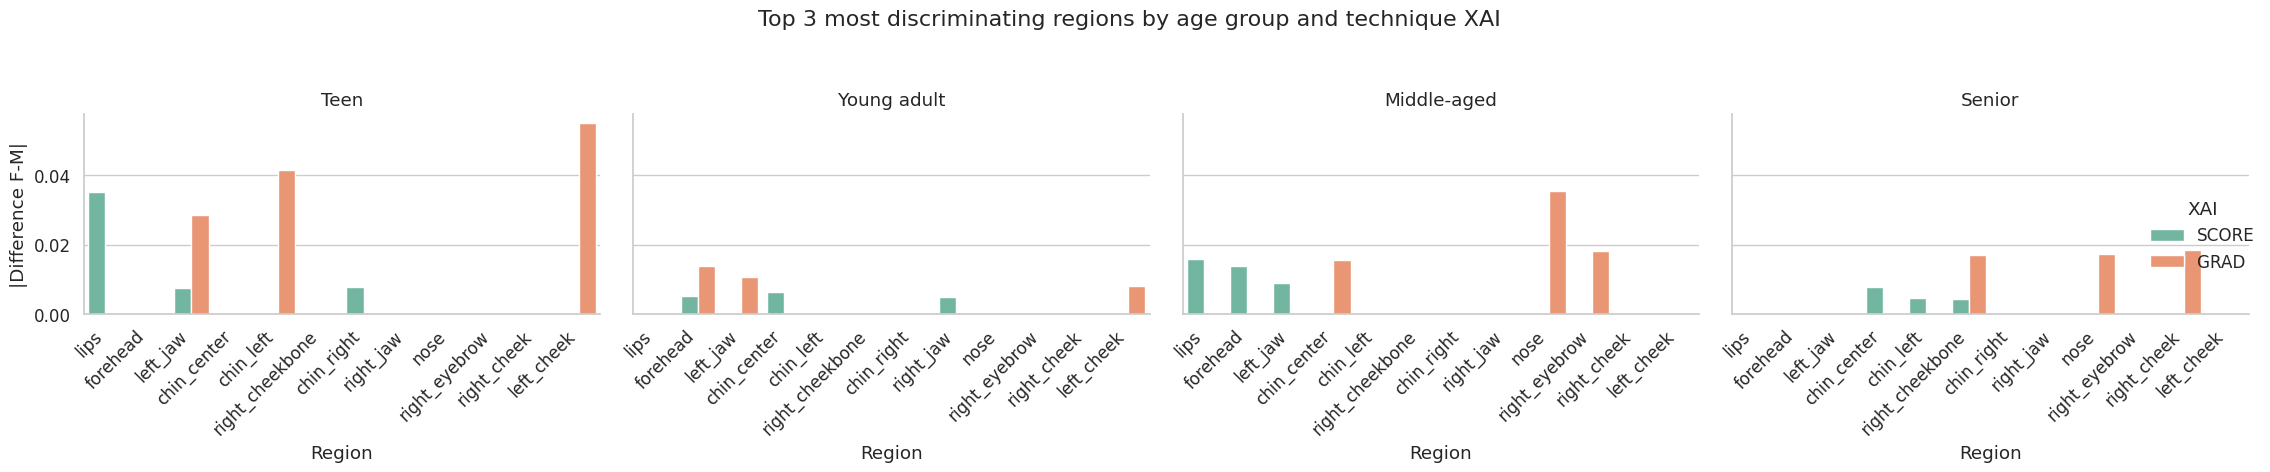

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo
sns.set(style="whitegrid", font_scale=1.1)

# Crear gráfico
g = sns.catplot(
    data=top3_total,
    kind="bar",
    x="Region", y="Absolute Difference",
    hue="Method", col="Age Group",
    col_order=["Teen", "Young adult", "Middle-aged", "Senior"],
    palette="Set2",
    height=4.5, aspect=1.2
)

g.set_titles("{col_name}")
g.set_axis_labels("Region", "|Difference F-M|")
g._legend.set_title("XAI")

# Rotar etiquetas
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

g.fig.suptitle("Top 3 most discriminating regions by age group and technique XAI", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


In [44]:
# Función para obtener predicción binaria de género (0 = Male, 1 = Female)
def predecir_clase(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0).to(device))
        prob = torch.sigmoid(output).item()
    return 1 if prob >= 0.5 else 0


In [45]:
# Recorrer val_loader y clasificar en aciertos/errores
activaciones_score = []
max_images = 5000
count = 0

for batch in test_loader:
    image, label, age, group_age, filename = batch
    image = image[0].to(device)
    label = int(label[0].item())
    group_age = group_age[0]
    filename = filename[0]

    # Predicción
    pred = predecir_clase(vgg_gender, image)
    correcto = int(pred == label)

    resultado = detectar_landmarks_y_mascaras(image.cpu())
    if resultado is None:
        continue
    puntos, masks = resultado

    # CAM Score
    cam_score = scorecam.generate_cam(image)
    act_score = cuantificar_activacion_soft(cam_score, masks)

    fila = {
        "label": label,
        "pred": pred,
        "correcto": correcto,
        "grupo_edad": group_age,
        "filename": filename
    }

    for region, valor in act_score.items():
        fila[region] = valor

    activaciones_score.append(fila)
    count += 1
    if count >= max_images:
        break

df_score_acc = pd.DataFrame(activaciones_score)


In [46]:
regiones_validas = [col for col in df_score_acc.columns if col not in ["label", "pred", "correcto", "grupo_edad", "filename"]]

# Calcular medias
media_correctos = df_score_acc[df_score_acc["correcto"] == 1][regiones_validas].mean()
media_errores = df_score_acc[df_score_acc["correcto"] == 0][regiones_validas].mean()

df_diff = pd.DataFrame({
    "Region": regiones_validas,
    "Correctness Average": media_correctos.values,
    "Incorrectness Average": media_errores.values,
    "Difference (Correct - Incorrect)": media_correctos.values - media_errores.values
}).sort_values("Difference (Correct - Incorrect)", ascending=False)

display(df_diff)


Region  Correctness Average  Incorrectness Average  \
17        right_jaw             0.021603               0.018492   
15    right_eyebrow             0.009143               0.006859   
5        chin_right             0.019169               0.016946   
12  right_cheekbone             0.008856               0.007255   
14     left_eyebrow             0.009736               0.008338   
9      right_temple             0.008319               0.007134   
11   left_cheekbone             0.006685               0.005517   
6        left_cheek             0.014704               0.013545   
7       right_cheek             0.019187               0.018052   
0          left_eye             0.004008               0.003076   
8       left_temple             0.007286               0.006408   
1         right_eye             0.003340               0.002824   
16         left_jaw             0.018432               0.018475   
13             nose             0.012045               0.012898   
4         chin_left             0.012161               0.014008   
2              lips             0.023825               0.027265   
10         forehead             0.046117               0.049702   
3       chin_center             0.013409               0.019318   
18            other             0.299723               0.311866   

    Difference (Correct - Incorrect)  
17                          0.003110  
15                          0.002284  
5                           0.002222  
12                          0.001601  
14                          0.001398  
9                           0.001185  
11                          0.001168  
6                           0.001159  
7                           0.001135  
0                           0.000932  
8                           0.000878  
1                           0.000516  
16                         -0.000043  
13                         -0.000853  
4                          -0.001847  
2                          -0.003440  
10                         -0.003585  
3                          -0.005910  
18                         -0.012143

/tmp/ipython-input-47-206749151.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_diff, x="Region", y="Difference (Correct - Incorrect)", palette="coolwarm")


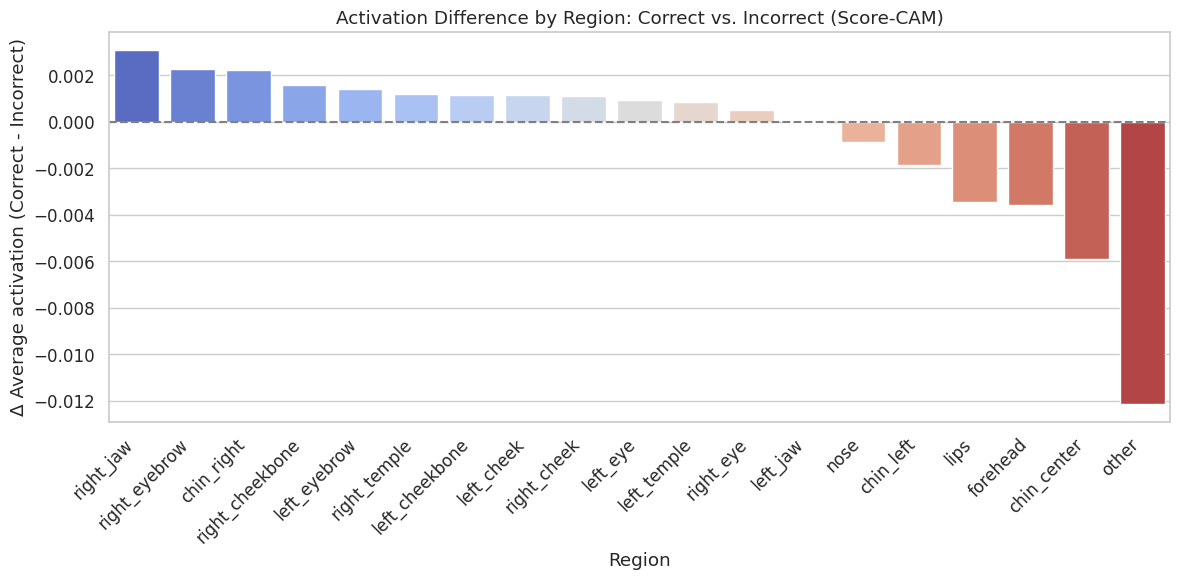

In [47]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_diff, x="Region", y="Difference (Correct - Incorrect)", palette="coolwarm")
plt.axhline(0, color="gray", linestyle="--")
plt.xticks(rotation=45, ha='right')
plt.title("Activation Difference by Region: Correct vs. Incorrect (Score-CAM)")
plt.ylabel("Δ Average activation (Correct - Incorrect)")
plt.tight_layout()
plt.show()


In [48]:
activaciones_grad = []
count = 0
max_images = 5000

for batch in test_loader:
    image, label, age, group_age, filename = batch
    image = image[0].to(device)
    label = int(label[0].item())
    group_age = group_age[0]
    filename = filename[0]

    # Predicción
    pred = predecir_clase(vgg_gender, image)
    correcto = int(pred == label)

    resultado = detectar_landmarks_y_mascaras(image.cpu())
    if resultado is None:
        continue
    puntos, masks = resultado

    # CAM Grad
    cam_grad = gradcam.generate_cam(image)
    act_grad = cuantificar_activacion_soft(cam_grad, masks)

    fila = {
        "label": label,
        "pred": pred,
        "correcto": correcto,
        "grupo_edad": group_age,
        "filename": filename
    }

    for region, valor in act_grad.items():
        fila[region] = valor

    activaciones_grad.append(fila)
    count += 1
    if count >= max_images:
        break

df_grad_acc = pd.DataFrame(activaciones_grad)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [49]:
regiones_validas = [col for col in df_grad_acc.columns if col not in ["label", "pred", "correcto", "grupo_edad", "filename"]]

media_correctos = df_grad_acc[df_grad_acc["correcto"] == 1][regiones_validas].mean()
media_errores = df_grad_acc[df_grad_acc["correcto"] == 0][regiones_validas].mean()

df_diff_grad = pd.DataFrame({
    "Region": regiones_validas,
    "Correctness Average": media_correctos.values,
    "Incorrectness Average": media_errores.values,
    "Difference (Correct - Incorrect)": media_correctos.values - media_errores.values
}).sort_values("Difference (Correct - Incorrect)", ascending=False)

display(df_diff_grad)


Region  Correctness Average  Incorrectness Average  \
16         left_jaw             0.020261               0.011429   
17        right_jaw             0.016724               0.011576   
11   left_cheekbone             0.008240               0.003177   
8       left_temple             0.006947               0.002904   
5        chin_right             0.014705               0.010758   
12  right_cheekbone             0.011460               0.008017   
9      right_temple             0.008937               0.006026   
14     left_eyebrow             0.013917               0.011756   
7       right_cheek             0.022527               0.020524   
6        left_cheek             0.018161               0.016554   
0          left_eye             0.005234               0.004576   
3       chin_center             0.013486               0.012865   
1         right_eye             0.004109               0.005043   
4         chin_left             0.014381               0.015371   
2              lips             0.024884               0.026343   
10         forehead             0.050503               0.055744   
15    right_eyebrow             0.012185               0.019063   
13             nose             0.020024               0.028283   
18            other             0.242290               0.264341   

    Difference (Correct - Incorrect)  
16                          0.008832  
17                          0.005147  
11                          0.005063  
8                           0.004043  
5                           0.003947  
12                          0.003443  
9                           0.002911  
14                          0.002161  
7                           0.002003  
6                           0.001607  
0                           0.000658  
3                           0.000622  
1                          -0.000934  
4                          -0.000990  
2                          -0.001459  
10                         -0.005242  
15                         -0.006878  
13                         -0.008259  
18                         -0.022050

/tmp/ipython-input-50-387374574.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_diff_grad, x="Region", y="Difference (Correct - Incorrect)", palette="coolwarm")


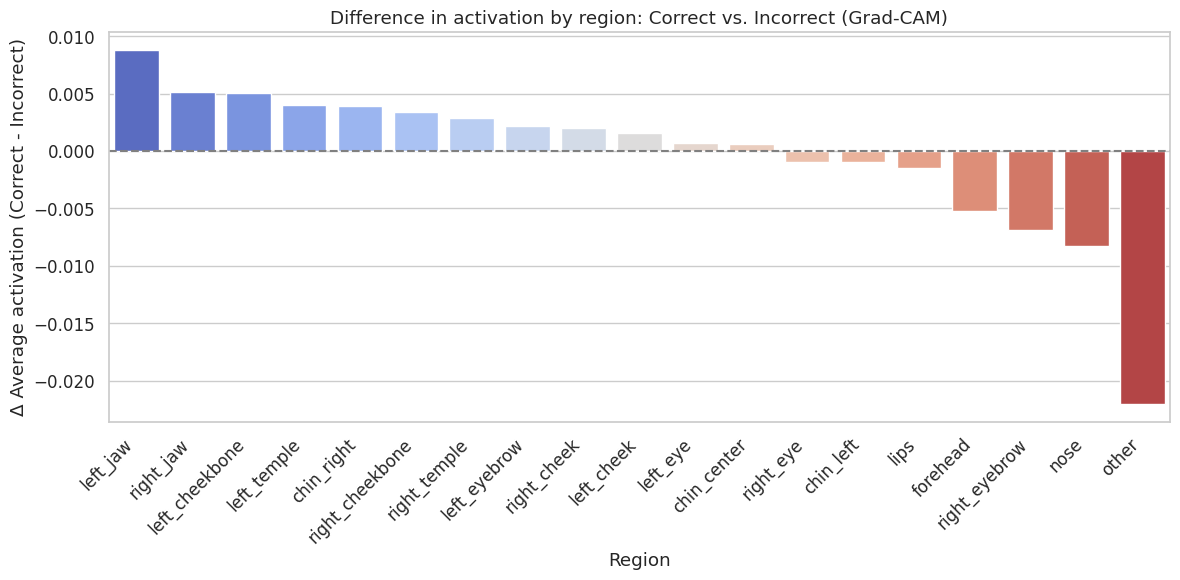

In [50]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_diff_grad, x="Region", y="Difference (Correct - Incorrect)", palette="coolwarm")
plt.axhline(0, color="gray", linestyle="--")
plt.xticks(rotation=45, ha='right')
plt.title("Difference in activation by region: Correct vs. Incorrect (Grad-CAM)")
plt.ylabel("Δ Average activation (Correct - Incorrect)")
plt.tight_layout()
plt.show()


In [51]:
# Agregamos columna de método
df_diff_score = df_diff.copy()
df_diff_score["Method"] = "Score-CAM"

df_diff_grad = df_diff_grad.copy()
df_diff_grad["Method"] = "Grad-CAM"

# Combinar ambos
df_comparado = pd.concat([df_diff_score, df_diff_grad], ignore_index=True)


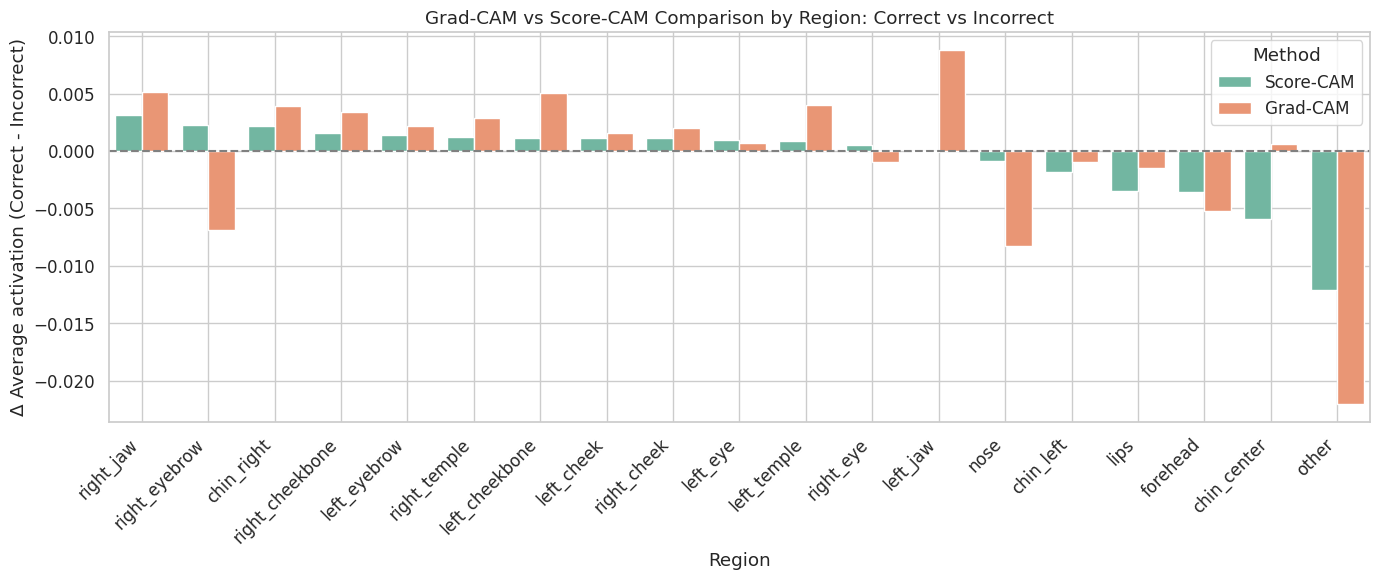

In [52]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df_comparado,
            x="Region", y="Difference (Correct - Incorrect)",
            hue="Method", palette="Set2")

plt.axhline(0, color="gray", linestyle="--")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Δ Average activation (Correct - Incorrect)")
plt.title("Grad-CAM vs Score-CAM Comparison by Region: Correct vs Incorrect")
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
from collections import defaultdict

# Diccionario para almacenar los mapas por grupo
mapas_por_grupo = defaultdict(list)

# Procesar el val_loader_balanceado
for batch in test_loader:
    image, label, age, group_age, filename = batch
    image = image[0].to(device)
    label = int(label[0].item())
    grupo = group_age[0]
    clase = "Female" if label == 1 else "Male"

    resultado = detectar_landmarks_y_mascaras(image.cpu())
    if resultado is None:
        continue
    _, masks = resultado

    cam_score = scorecam.generate_cam(image)
    act_score = cuantificar_activacion_soft(cam_score, masks)
    mapa_score = generar_semantic_map(act_score, masks)

    mapas_por_grupo[(clase, grupo)].append(mapa_score)


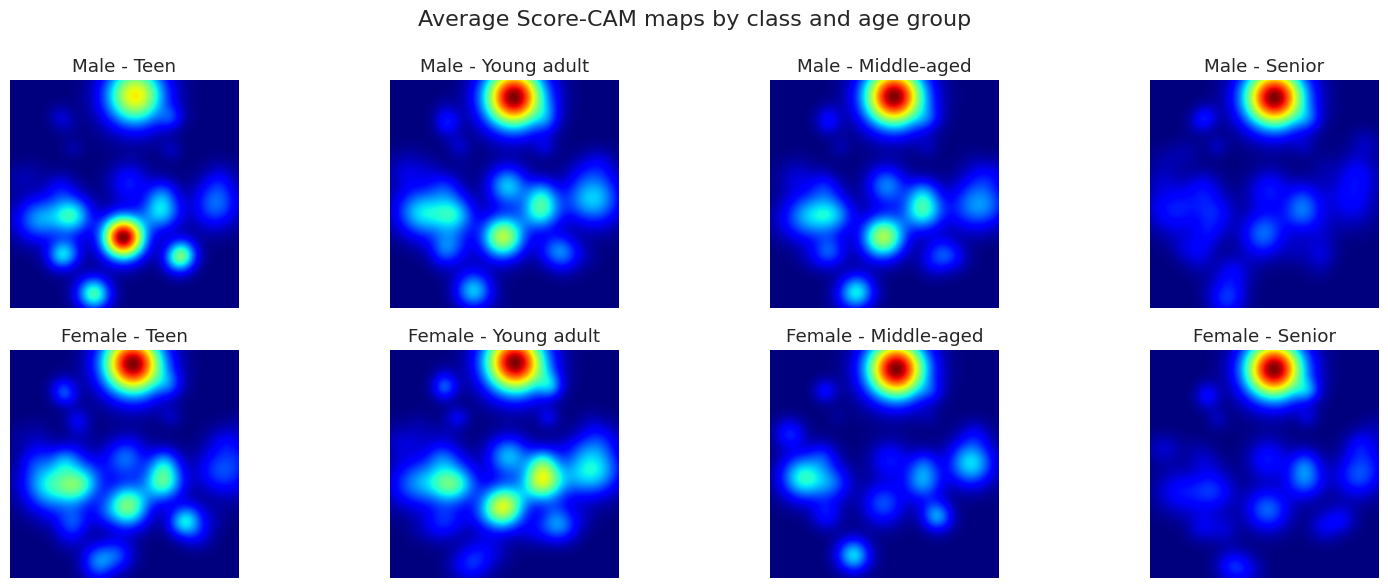

In [54]:
# Mostrar promedio por grupo
import matplotlib.pyplot as plt

grupos_orden = ["Teen", "Young adult", "Middle-aged", "Senior"]
clases_orden = ["Male", "Female"]

fig, axs = plt.subplots(len(clases_orden), len(grupos_orden), figsize=(16, 6))

for i, clase in enumerate(clases_orden):
    for j, grupo in enumerate(grupos_orden):
        key = (clase, grupo)
        mapas = mapas_por_grupo.get(key, [])
        if mapas:
            promedio = np.mean(np.stack(mapas), axis=0)
            axs[i, j].imshow(promedio, cmap="jet")
            axs[i, j].set_title(f"{clase} - {grupo}")
        else:
            axs[i, j].text(0.5, 0.5, "Sin datos", ha="center")
        axs[i, j].axis("off")

plt.suptitle("Average Score-CAM maps by class and age group", fontsize=16)
plt.tight_layout()
plt.show()


In [55]:
mapas_grad_por_grupo = defaultdict(list)

for batch in test_loader:
    image, label, age, group_age, filename = batch
    image = image[0].to(device)
    label = int(label[0].item())
    grupo = group_age[0]
    clase = "Female" if label == 1 else "Male"

    resultado = detectar_landmarks_y_mascaras(image.cpu())
    if resultado is None:
        continue
    _, masks = resultado

    cam_grad = gradcam.generate_cam(image)
    act_grad = cuantificar_activacion_soft(cam_grad, masks)
    mapa_grad = generar_semantic_map(act_grad, masks)

    mapas_grad_por_grupo[(clase, grupo)].append(mapa_grad)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


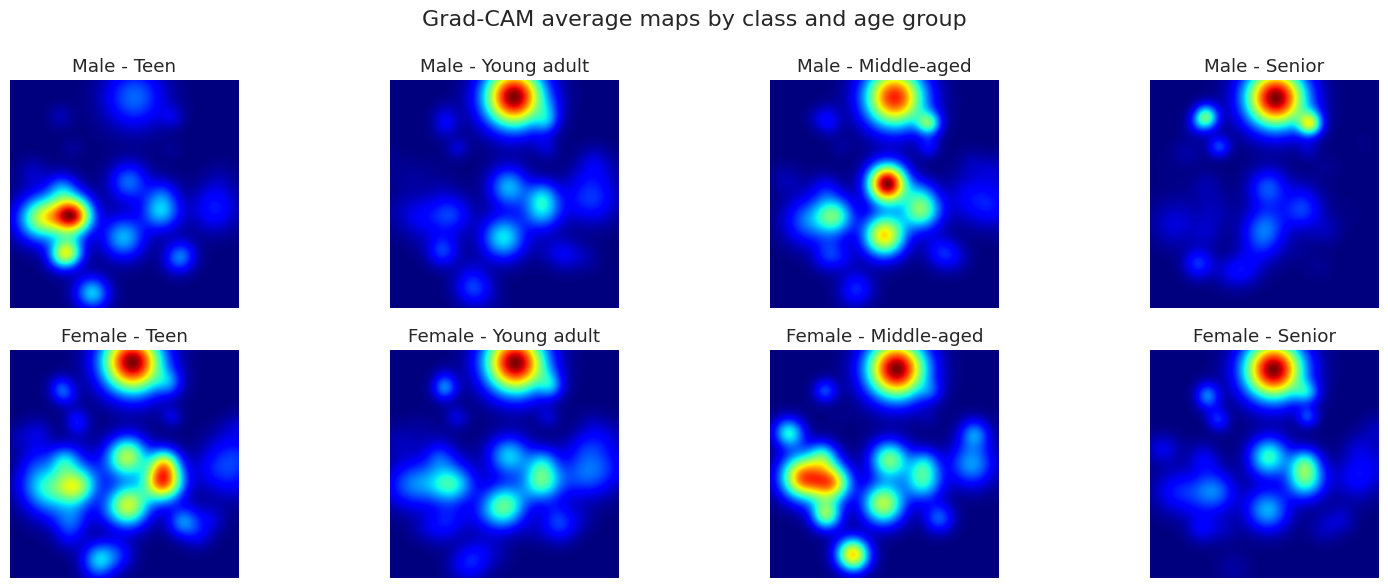

In [56]:
fig, axs = plt.subplots(len(clases_orden), len(grupos_orden), figsize=(16, 6))

for i, clase in enumerate(clases_orden):
    for j, grupo in enumerate(grupos_orden):
        key = (clase, grupo)
        mapas = mapas_grad_por_grupo.get(key, [])
        if mapas:
            promedio = np.mean(np.stack(mapas), axis=0)
            axs[i, j].imshow(promedio, cmap="jet")
            axs[i, j].set_title(f"{clase} - {grupo}")
        else:
            axs[i, j].text(0.5, 0.5, "Sin datos", ha="center")
        axs[i, j].axis("off")

plt.suptitle("Grad-CAM average maps by class and age group", fontsize=16)
plt.tight_layout()
plt.show()


In [57]:
import cv2
from scipy.stats import pearsonr

def analizar_robustez_blur(image_tensor, label, cam_func, metodo="Score-CAM"):
    # Imagen original
    resultado = detectar_landmarks_y_mascaras(image_tensor.cpu())
    if resultado is None:
        print("❌ No se detectaron landmarks.")
        return
    _, masks = resultado

    # CAM original
    cam_original = cam_func.generate_cam(image_tensor)
    act_orig = cuantificar_activacion_soft(cam_original, masks)
    mapa_orig = generar_semantic_map(act_orig, masks)

    # Aplicar desenfoque
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
    image_np = np.clip(image_np, 0, 1)
    image_blur = cv2.GaussianBlur((image_np * 255).astype(np.uint8), (9, 9), 5)

    # Volver a tensor
    image_blur_tensor = transforms.ToTensor()(Image.fromarray(image_blur)).to(device)

    # CAM con imagen desenfocada
    cam_blur = cam_func.generate_cam(image_blur_tensor)
    act_blur = cuantificar_activacion_soft(cam_blur, masks)
    mapa_blur = generar_semantic_map(act_blur, masks)

    # Correlación entre activaciones
    regiones = list(act_orig.keys())
    orig_vals = [act_orig[r] for r in regiones]
    blur_vals = [act_blur[r] for r in regiones]
    correlacion, _ = pearsonr(orig_vals, blur_vals)

    # Visualización
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(mapa_orig, cmap="jet")
    axs[0].set_title("Original map")

    axs[1].imshow(mapa_blur, cmap="jet")
    axs[1].set_title("Map with blur")
    for ax in axs: ax.axis("off")
    plt.suptitle(f"{metodo} - Correlation activations: {correlacion:.2f}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return correlacion


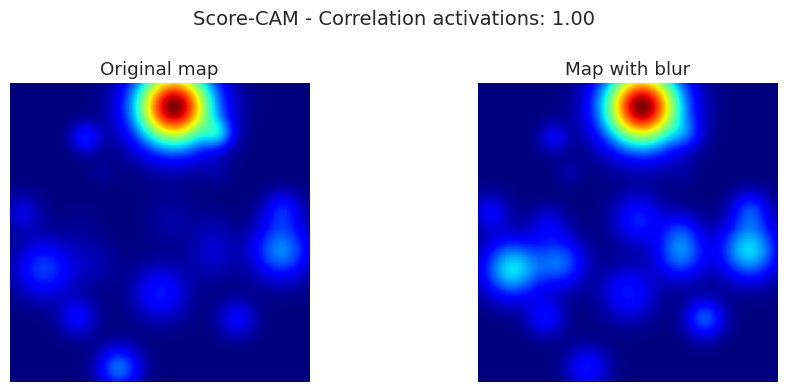

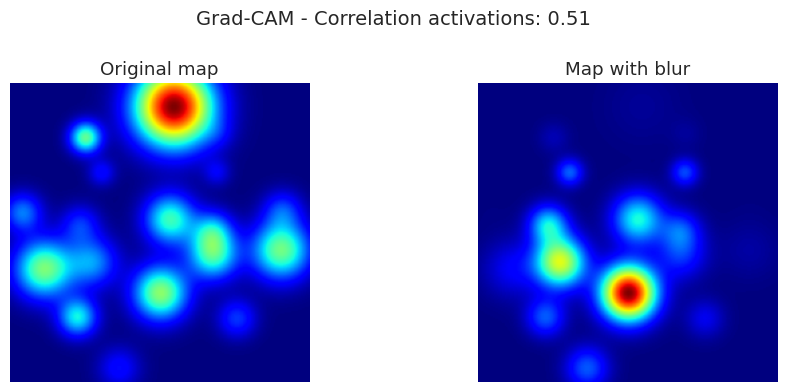

In [58]:
# Tomar una imagen
sample_batch = next(iter(test_loader))
image = sample_batch[0][0].to(device)
label = int(sample_batch[1][0].item())

# Ejecutar análisis para Score-CAM
cor_score = analizar_robustez_blur(image, label, scorecam, metodo="Score-CAM")

# Ejecutar análisis para Grad-CAM
cor_grad = analizar_robustez_blur(image, label, gradcam, metodo="Grad-CAM")


In [59]:
def evaluar_robustez_lote(val_loader, cam_func, metodo="Score-CAM", max_images=100):
    correlaciones = []
    count = 0

    for batch in val_loader:
        image, label, *_ = batch
        image = image[0].to(device)
        label = int(label[0].item())

        resultado = detectar_landmarks_y_mascaras(image.cpu())
        if resultado is None:
            continue
        _, masks = resultado

        try:
            # Imagen original
            cam_orig = cam_func.generate_cam(image)
            act_orig = cuantificar_activacion_soft(cam_orig, masks)

            # Imagen desenfocada
            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            image_np = np.clip(image_np, 0, 1)
            image_blur = cv2.GaussianBlur((image_np * 255).astype(np.uint8), (9, 9), 5)
            image_blur_tensor = transforms.ToTensor()(Image.fromarray(image_blur)).to(device)

            cam_blur = cam_func.generate_cam(image_blur_tensor)
            act_blur = cuantificar_activacion_soft(cam_blur, masks)

            regiones = list(act_orig.keys())
            vals_orig = [act_orig[r] for r in regiones]
            vals_blur = [act_blur[r] for r in regiones]

            corr, _ = pearsonr(vals_orig, vals_blur)
            correlaciones.append(corr)
            count += 1

        except Exception as e:
            print(f"Error en imagen {count}: {e}")
            continue

        if count >= max_images:
            break

    return correlaciones


In [60]:
corrs_score = evaluar_robustez_lote(test_loader, scorecam, metodo="Score-CAM", max_images=1000)
corrs_grad = evaluar_robustez_lote(test_loader, gradcam, metodo="Grad-CAM", max_images=1000)

print(f"Average Score-CAM correlation (n={len(corrs_score)}): {np.mean(corrs_score):.3f}")
print(f"Grad-CAM average correlation  (n={len(corrs_grad)}): {np.mean(corrs_grad):.3f}")


Average Score-CAM correlation (n=66): 0.986
Grad-CAM average correlation  (n=66): 0.671


In [61]:
# Crear DataFrame para visualización
df_corr = pd.DataFrame({
    "Correlation": corrs_score + corrs_grad,
    "Method": ["Score-CAM"] * len(corrs_score) + ["Grad-CAM"] * len(corrs_grad)
})


/tmp/ipython-input-62-1790122935.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_corr, x="Method", y="Correlation", palette="Set2")
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 40.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 28.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


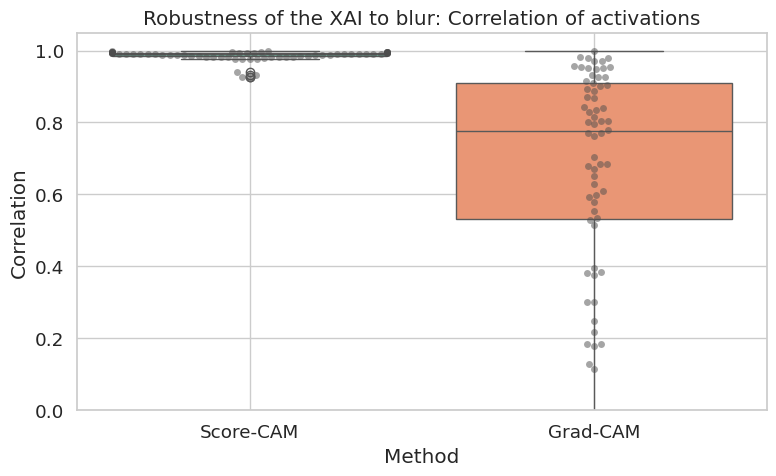

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_corr, x="Method", y="Correlation", palette="Set2")
sns.swarmplot(data=df_corr, x="Method", y="Correlation", color=".3", alpha=0.5)

plt.title("Robustness of the XAI to blur: Correlation of activations")
plt.ylim(0, 1.05)
plt.tight_layout()
plt.grid(True)
plt.show()


In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Extraer vectores por imagen
regiones_sem = [col for col in df.columns if col.endswith("_score") and "other" not in col]
X = df[regiones_sem].copy()
y_genero = df["Gender"]
y_edad = df["age_group"]

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [64]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2f}")


Explained variance: 0.36


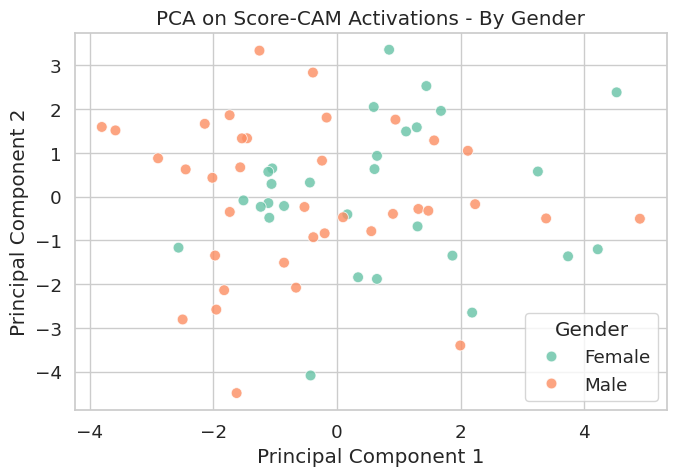

In [65]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_genero, palette="Set2", s=60, alpha=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA on Score-CAM Activations - By Gender")
plt.grid(True)
plt.tight_layout()
plt.show()


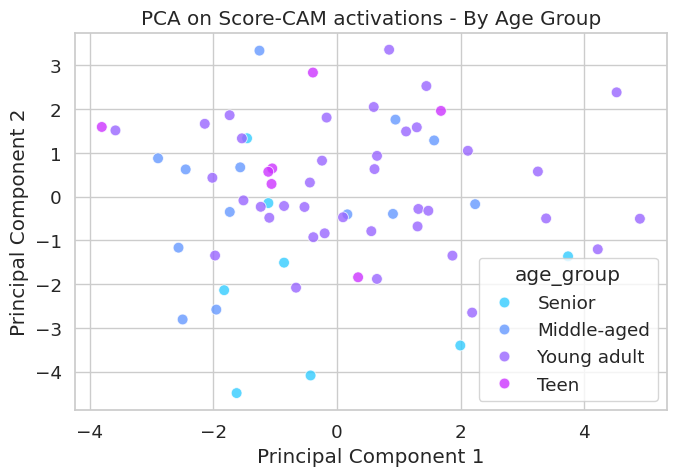

In [66]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_edad, palette="cool", s=60, alpha=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA on Score-CAM activations - By Age Group")
plt.grid(True)
plt.tight_layout()
plt.show()


In [67]:
# Extraer columnas de activación Grad-CAM
regiones_grad = [col for col in df.columns if col.endswith("_grad") and "other" not in col]
X_grad = df[regiones_grad].copy()
y_genero = df["Gender"]
y_edad = df["age_group"]

# Escalar
X_grad_scaled = scaler.fit_transform(X_grad)


In [68]:
pca_grad = PCA(n_components=2)
X_pca_grad = pca_grad.fit_transform(X_grad_scaled)

print(f"Explained variance (Grad-CAM): {pca_grad.explained_variance_ratio_.sum():.2f}")


Explained variance (Grad-CAM): 0.35


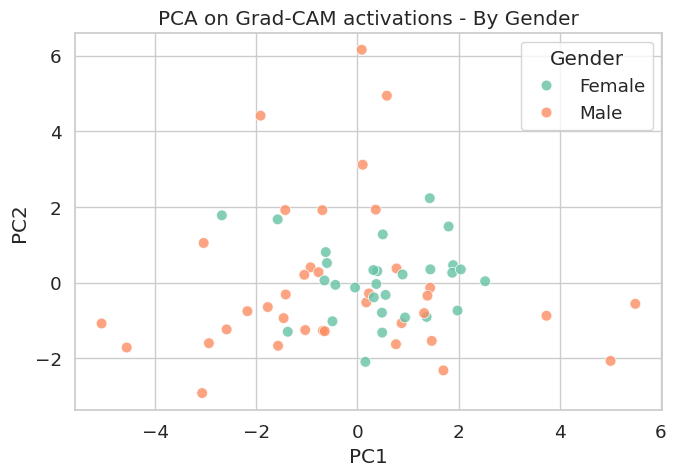

In [69]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_pca_grad[:, 0], y=X_pca_grad[:, 1], hue=y_genero, palette="Set2", s=60, alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Grad-CAM activations - By Gender")
plt.grid(True)
plt.tight_layout()
plt.show()


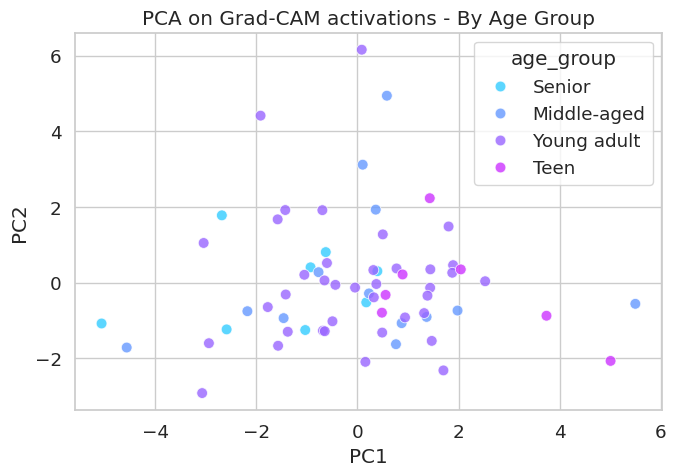

In [70]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_pca_grad[:, 0], y=X_pca_grad[:, 1], hue=y_edad, palette="cool", s=60, alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Grad-CAM activations - By Age Group")
plt.grid(True)
plt.tight_layout()
plt.show()


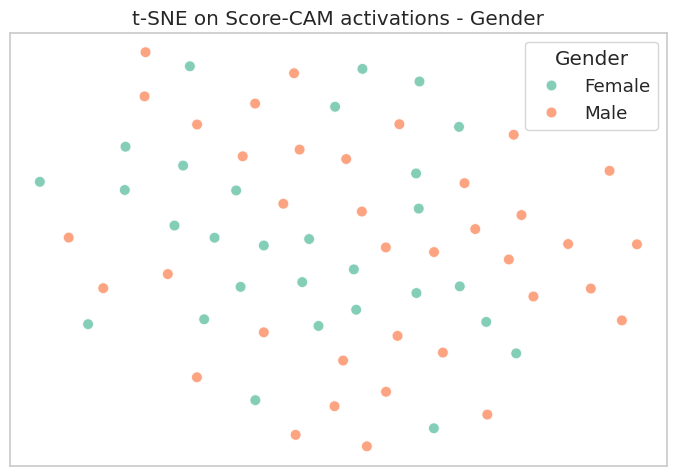

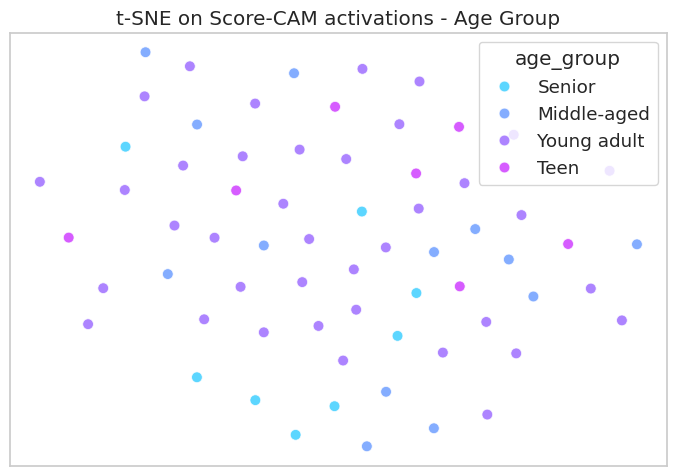

In [71]:
from sklearn.manifold import TSNE

# Aplicar t-SNE a activaciones Score-CAM
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_score = tsne.fit_transform(X_scaled)

# Visualizar por género
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_tsne_score[:, 0], y=X_tsne_score[:, 1], hue=y_genero, palette="Set2", s=60, alpha=0.8)
plt.title("t-SNE on Score-CAM activations - Gender")
plt.xticks([])
plt.yticks([])
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualizar por grupo de edad
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_tsne_score[:, 0], y=X_tsne_score[:, 1], hue=y_edad, palette="cool", s=60, alpha=0.8)
plt.title("t-SNE on Score-CAM activations - Age Group")
plt.xticks([])
plt.yticks([])
plt.grid(True)
plt.tight_layout()
plt.show()


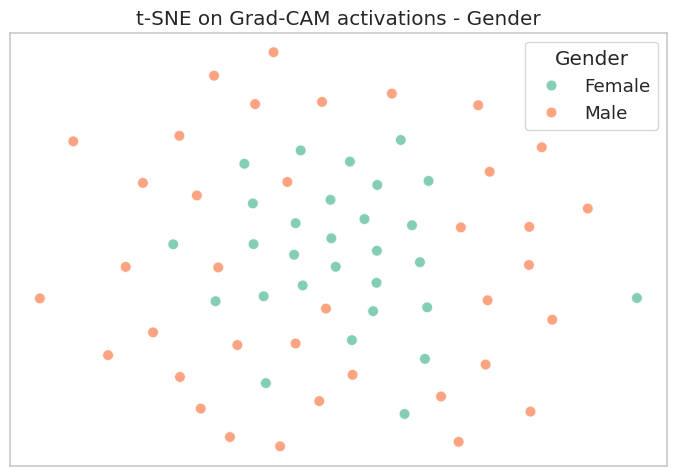

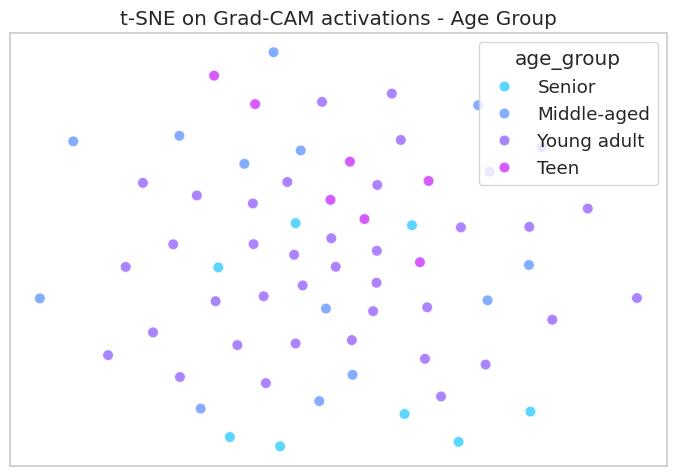

In [72]:
# Aplicar t-SNE a activaciones Grad-CAM
tsne_grad = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne_grad = tsne_grad.fit_transform(X_grad_scaled)

# Visualizar por género
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_tsne_grad[:, 0], y=X_tsne_grad[:, 1], hue=y_genero, palette="Set2", s=60, alpha=0.8)
plt.title("t-SNE on Grad-CAM activations - Gender")
plt.xticks([])
plt.yticks([])
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualizar por grupo de edad
plt.figure(figsize=(7, 5))
sns.scatterplot(x=X_tsne_grad[:, 0], y=X_tsne_grad[:, 1], hue=y_edad, palette="cool", s=60, alpha=0.8)
plt.title("t-SNE on Grad-CAM activations - Age Group")
plt.xticks([])
plt.yticks([])
plt.grid(True)
plt.tight_layout()
plt.show()
